In [20]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'


import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
obs_path = f'{RESULT_TABLE}/GEX_OBS.csv'
mp_anno_path = f'{RESULT_TABLE}/MPs/CD8T/MetaProgram_Annotation.csv'
mp_gmt_path = f'{RESULT_TABLE}/MPs/CD8T/MP_Programs.gmt'
scores_path = f'{RESULT_TABLE}/MPs/CD8T/signature_scores.csv'
## Load data
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(obs_path,index_col=0)

In [18]:
f"We captured {(obs.Lineage=='T').sum():,} T cells, of which ({(obs.Celltype=='CD8T').sum()/(obs.Lineage=='T').sum():.1%}) {(obs.Celltype=='CD8T').sum():,} most are CD8+ T cells"

'We captured 18,772 T cells, of which (91.8%) 17,230 most are CD8+ T cells'

In [27]:
tcells = adata[adata.obs.index.isin(obs.index[obs.Lineage=='T']),:].copy()

In [28]:
sp.utils.log1pNorm(adata)
for c in ['Celltype','BestResponse','Patient','Timepoint','Sample_Short','Treatment_Arm','RCB']:
    tcells.obs[c] = obs.loc[tcells.obs.index,c]

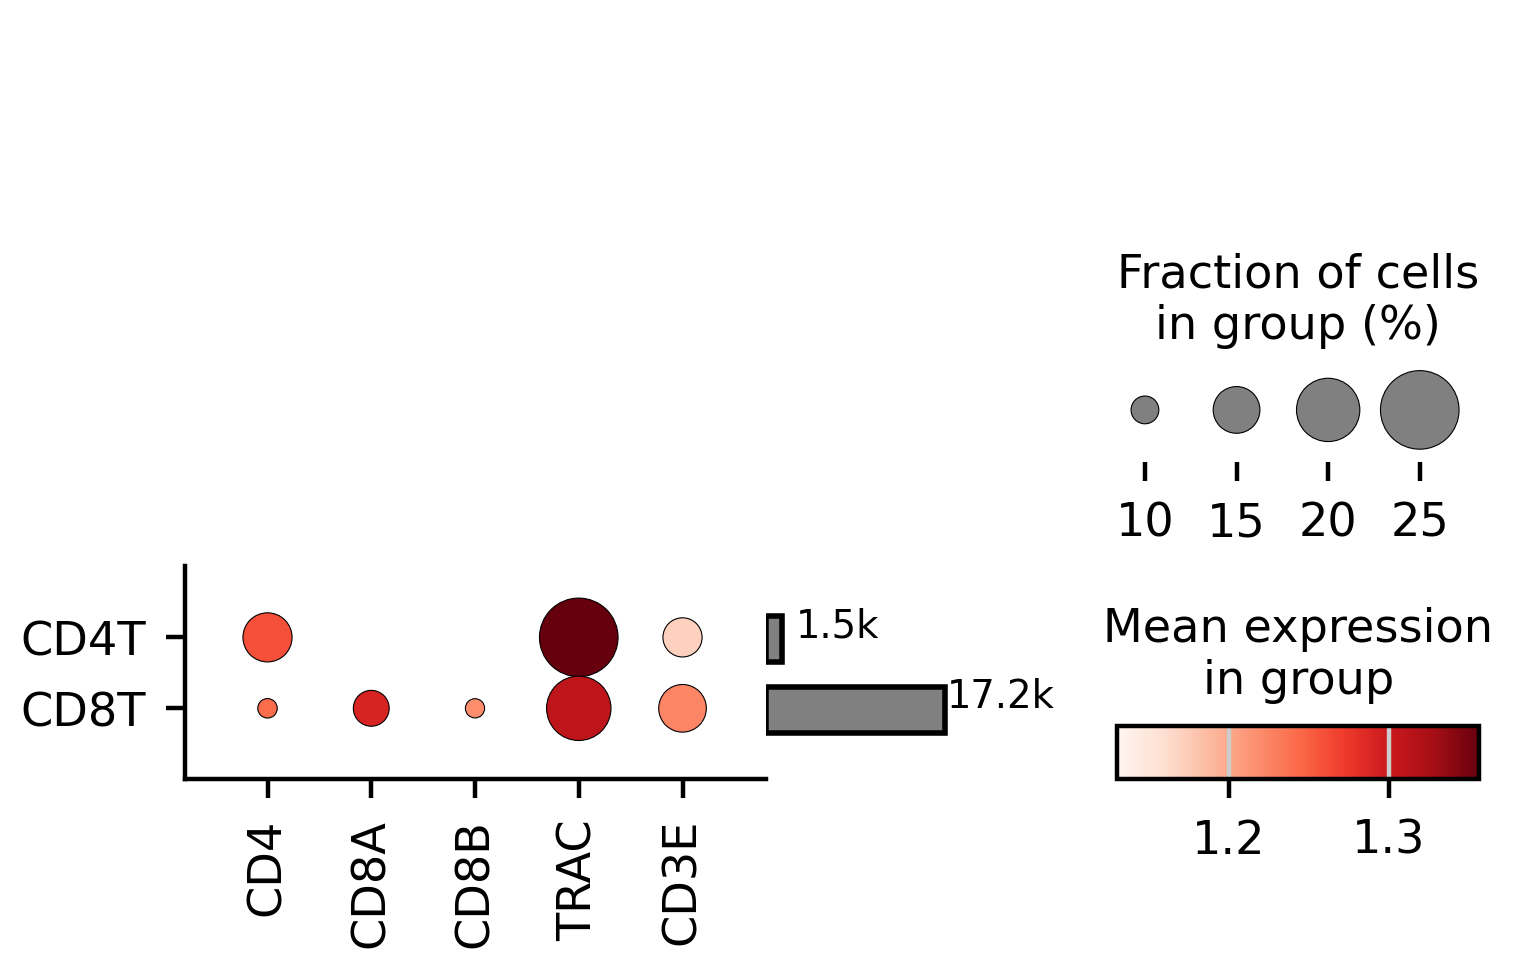

In [29]:
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp = sc.pl.dotplot(tcells,['CD4','CD8A','CD8B','TRAC','CD3E'],groupby='Celltype',mean_only_expressed=True,return_fig=True)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap='Reds',dot_max=.25,dot_min=.05)
dp.show()

# CD8 T cells

In [51]:
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
adata = adata[adata.obs.index.isin(obs.index[obs.Celltype=='CD8T']),:]
for c in ['Cellstate','BestResponse','Patient','Timepoint','Sample_Short','Treatment_Arm','RCB']:
    adata.obs[c] = obs.loc[adata.obs.index,c]
print(f'{adata.obs.shape[0]:,} CD8 T cells')

17,230 CD8 T cells


# Olivera Signature scoring 

In [31]:
oliveira_sig = (pd.read_excel(f"{EXTERNAL_DATA}/Oliveira_Giacomo_et_al-2021-Nature.xlsx",
                                sheet_name='Supplementary Table 8',
                               skiprows=3).
                   loc[:,:'TTE'].
                   dropna(axis=1,how='all').
                   replace('C16orf45','BMERB1'). # name conversion
                   replace('RARRES3','PLAAT4').
                   replace('SEPT7','SEPTIN7')
                  )
ext_sig_gmt_path =f'{EXTERNAL_DATA}/Oliveira_Giacomo_et_al-2021-Nature.gmt'
with open(ext_sig_gmt_path,'w') as f:
    for c in oliveira_sig:
        f.write('\t'.join([c,'Oliveira_Giacomo_et_al-2021']+oliveira_sig[c].dropna().tolist())+'\n')
    

In [32]:
mp_result = sp.ext.VISION(data=adata,gmt_files=[ext_sig_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ..//data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt --h5ad /tmp/tmp7ejnv4i8/count.h5ad --output_file /tmp/tmp7ejnv4i8/vision.tsv
$gmt_files
[1] "..//data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt"

$h5ad
[1] "/tmp/tmp7ejnv4i8/count.h5ad"

$output_file
[1] "/tmp/tmp7ejnv4i8/vision.tsv"



Loading data from ..//data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt ...

Using 21107/35002 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...

Warning messages:
1: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 4.5 GiB
2: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 4.5 GiB


In [33]:
mp_result['Cellstate'] = adata.obs['Cellstate']

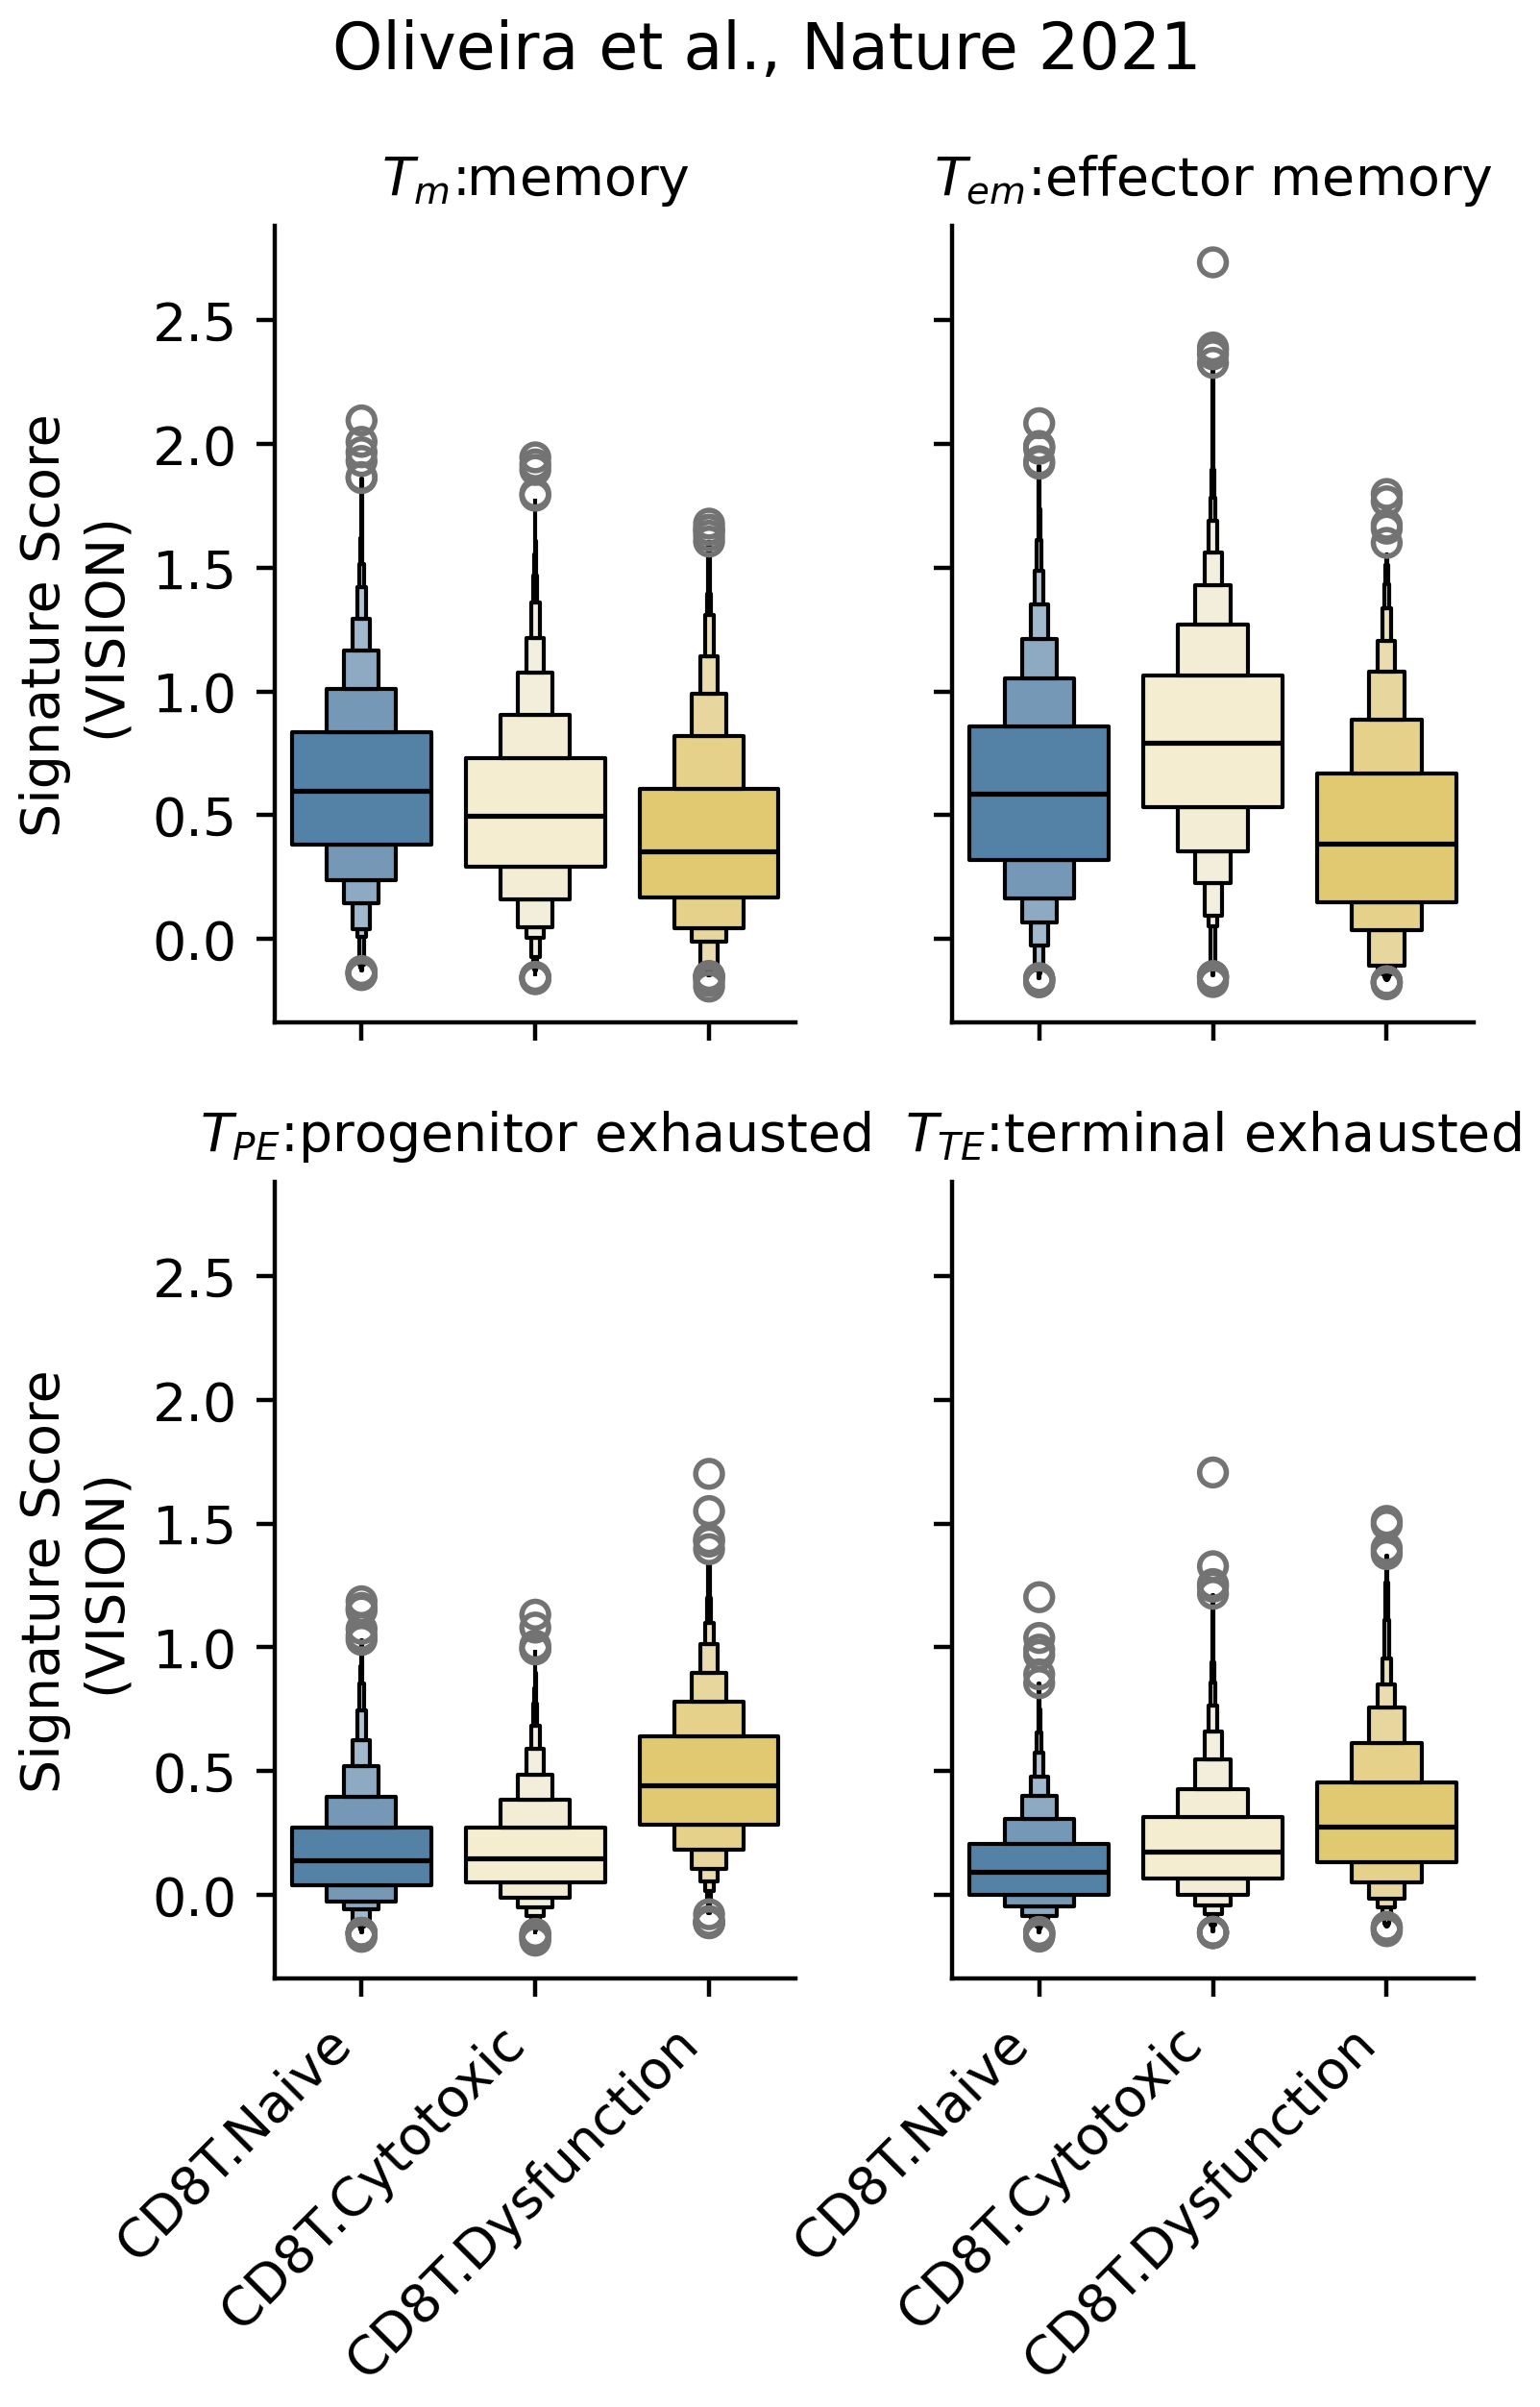

In [34]:
fig,axs = plt.subplots(2,2,sharey=True,sharex=True,dpi=200,figsize=(4,6))

ax=axs[0,0]
y='TM'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_m$:memory',xlabel='')
ax.grid(False)

ax=axs[0,1]
y='TEM'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_{em}$:effector memory',xlabel='')
ax.grid(False)

ax=axs[1,0]
y='TPE'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_{PE}$:progenitor exhausted',xlabel='')
ax.grid(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax=axs[1,1]
y='TTE'
sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],palette=COLOR_PAlETTE['Cellstate'],
                  ax=ax)
ax.set(ylabel='Signature Score\n(VISION)',title=r'$T_{TE}$:terminal exhausted',xlabel='')
ax.grid(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('Oliveira et al., Nature 2021',y=1);
plt.subplots_adjust(hspace=0.2,wspace=.3)

# GEX log1p Normalization

In [36]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)
sp.utils.log1pNorm(adata)

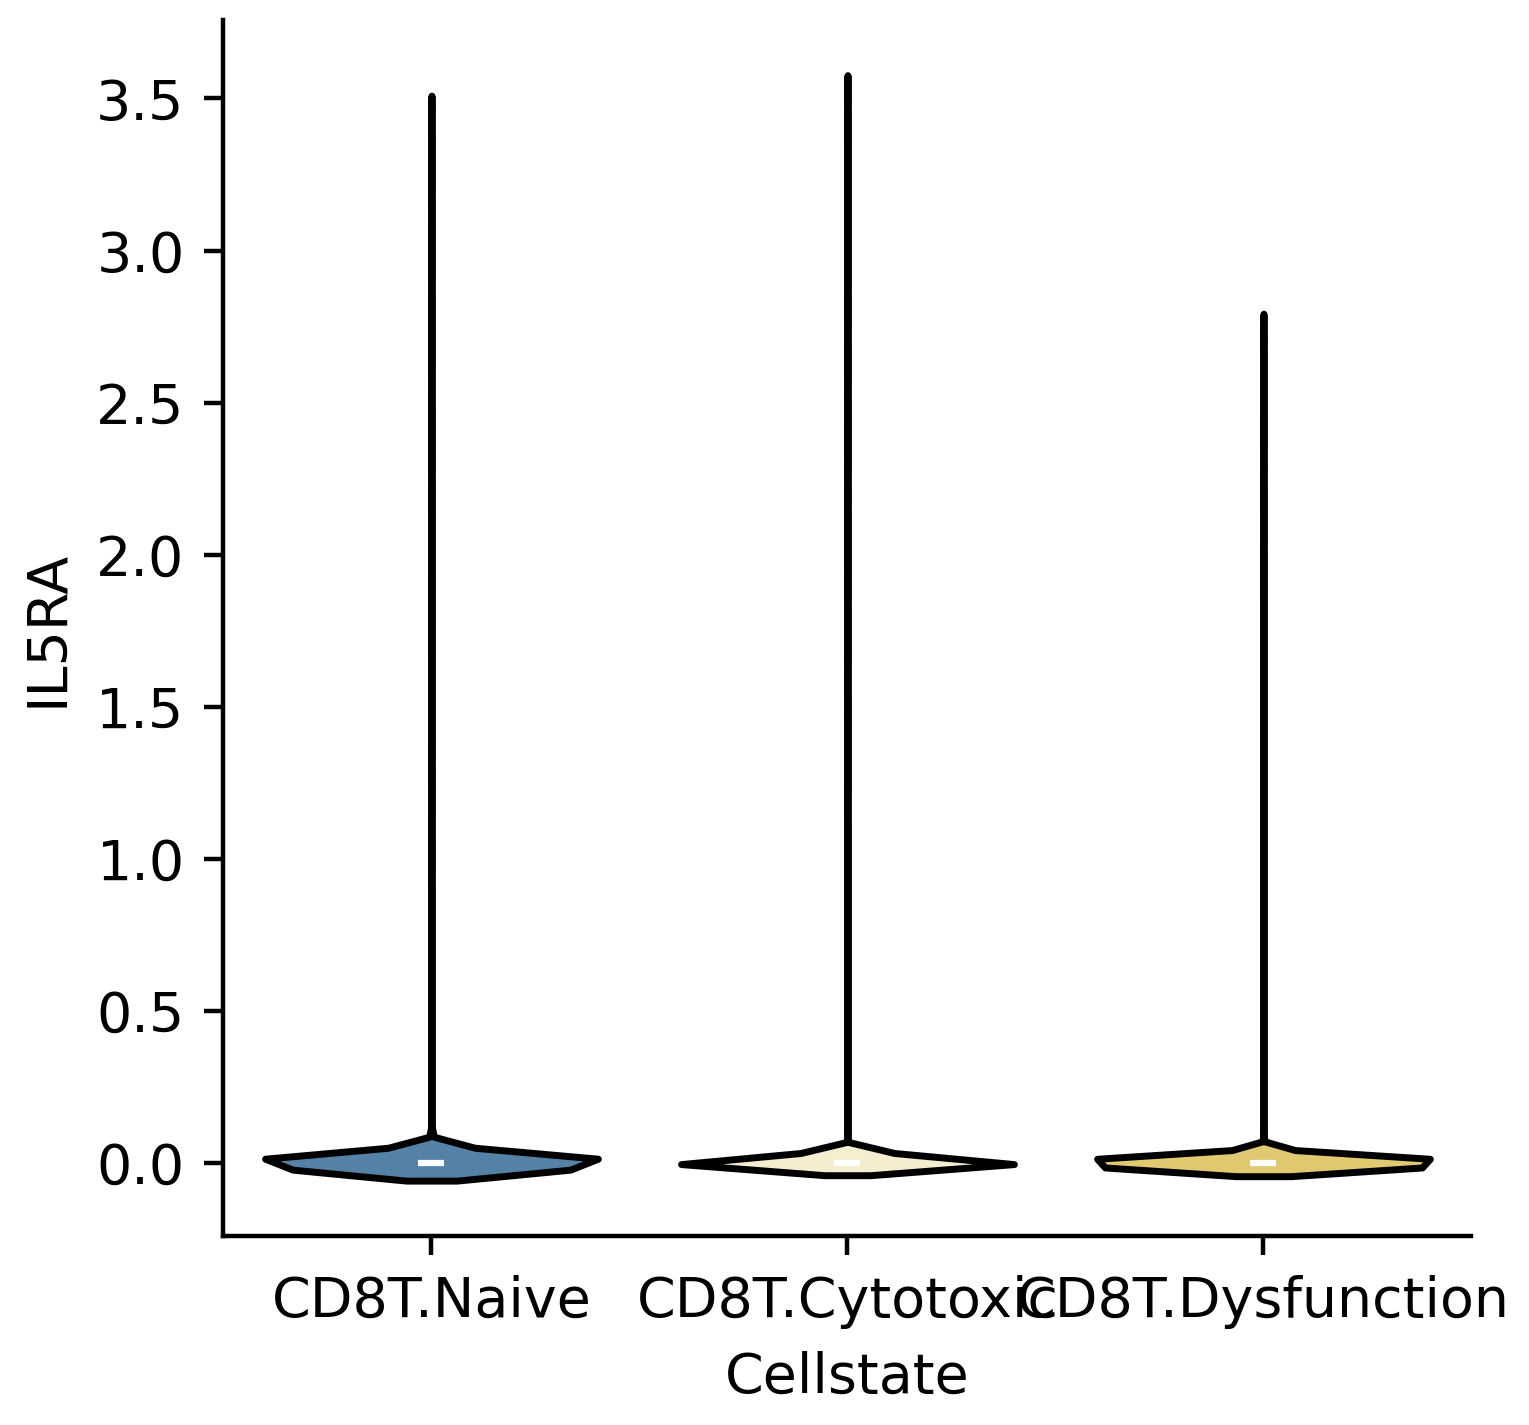

In [37]:
y='IL5RA'
data = sc.get.obs_df(adata,['Cellstate',y])
ax = sns.violinplot(data=data,x='Cellstate',y=y,
                   order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Dysfunction'],
               palette=COLOR_PAlETTE['Cellstate'])
ax.grid(False)

# Heatmap visualization on genes in each MPs

## Load MPs geneset

In [11]:
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

## Visualize MPs in heatmap

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 72.61716666666668 mm


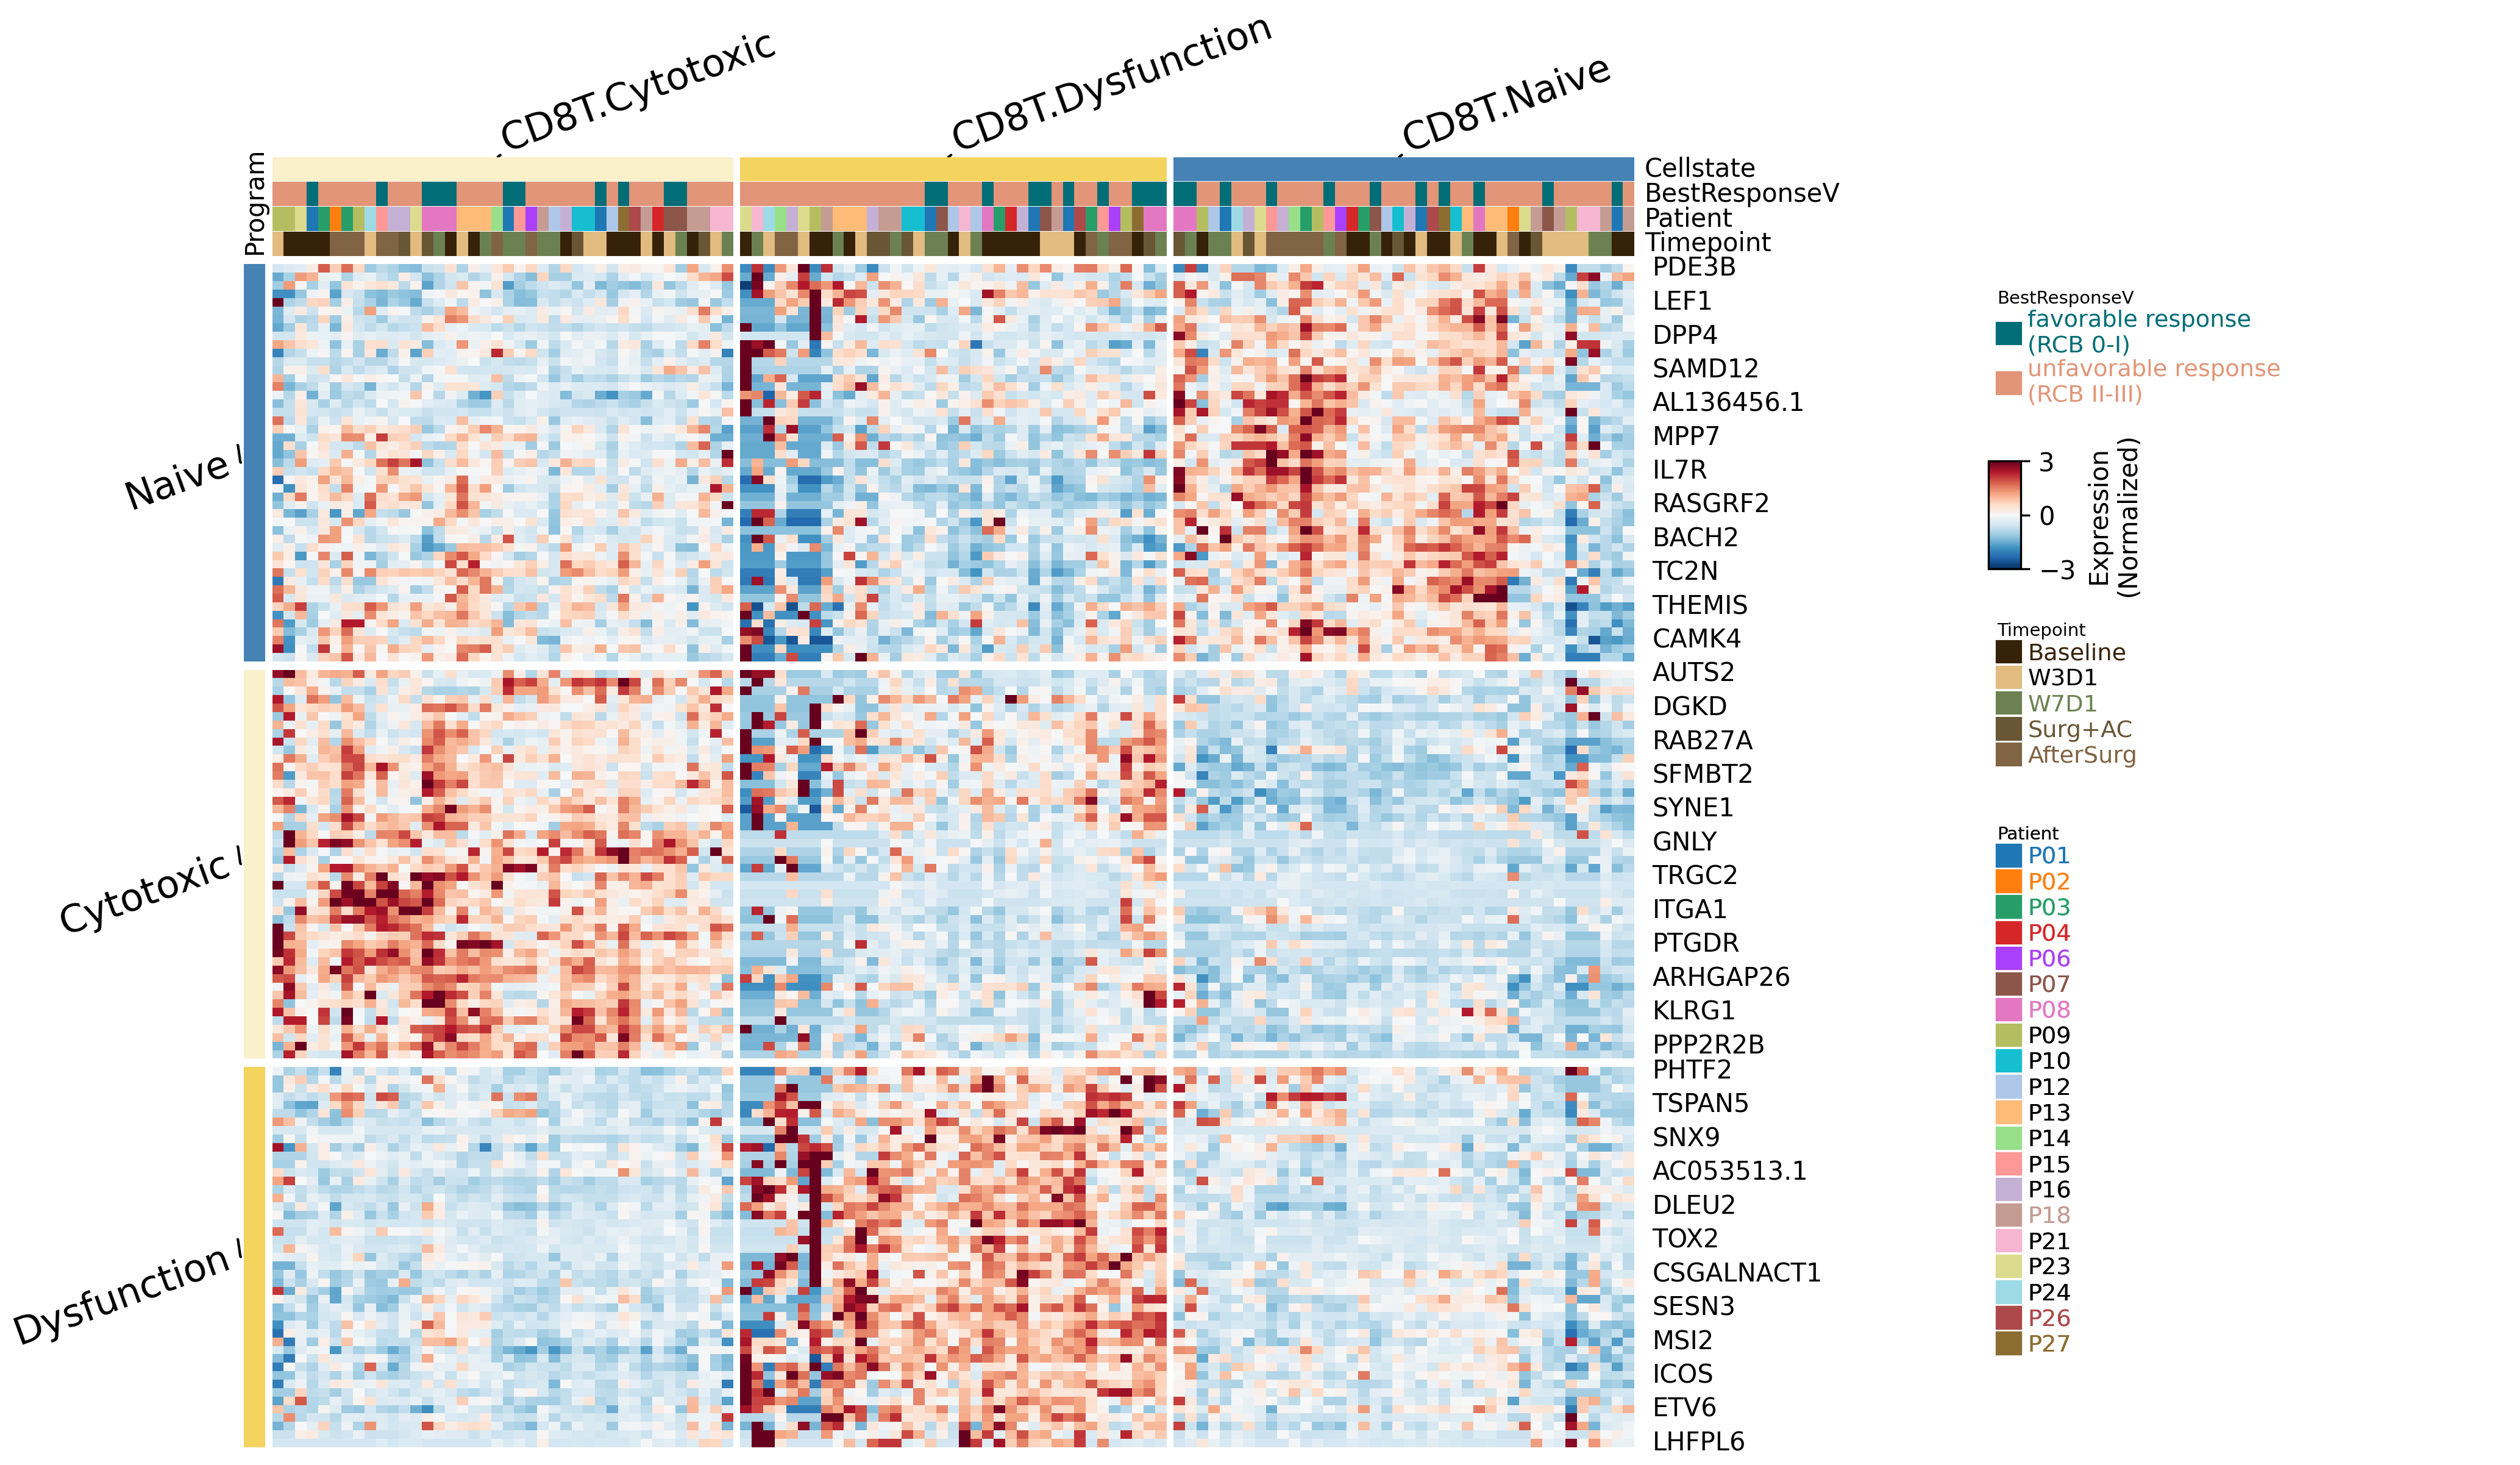

In [42]:
CELLTYPE='CD8T'
palette={}
palette['Program'] = {k.replace(f'{CELLTYPE}.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if CELLTYPE in k}
for c in ['BestResponseV','Patient','Timepoint','Cellstate']:
    palette[c] = COLOR_PAlETTE[c.replace('V','')]
adata.obs['BestResponseV'] = adata.obs.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
aggregate_heatmap(adata=adata,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','BestResponseV','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(10,8),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 72.61716666666668 mm


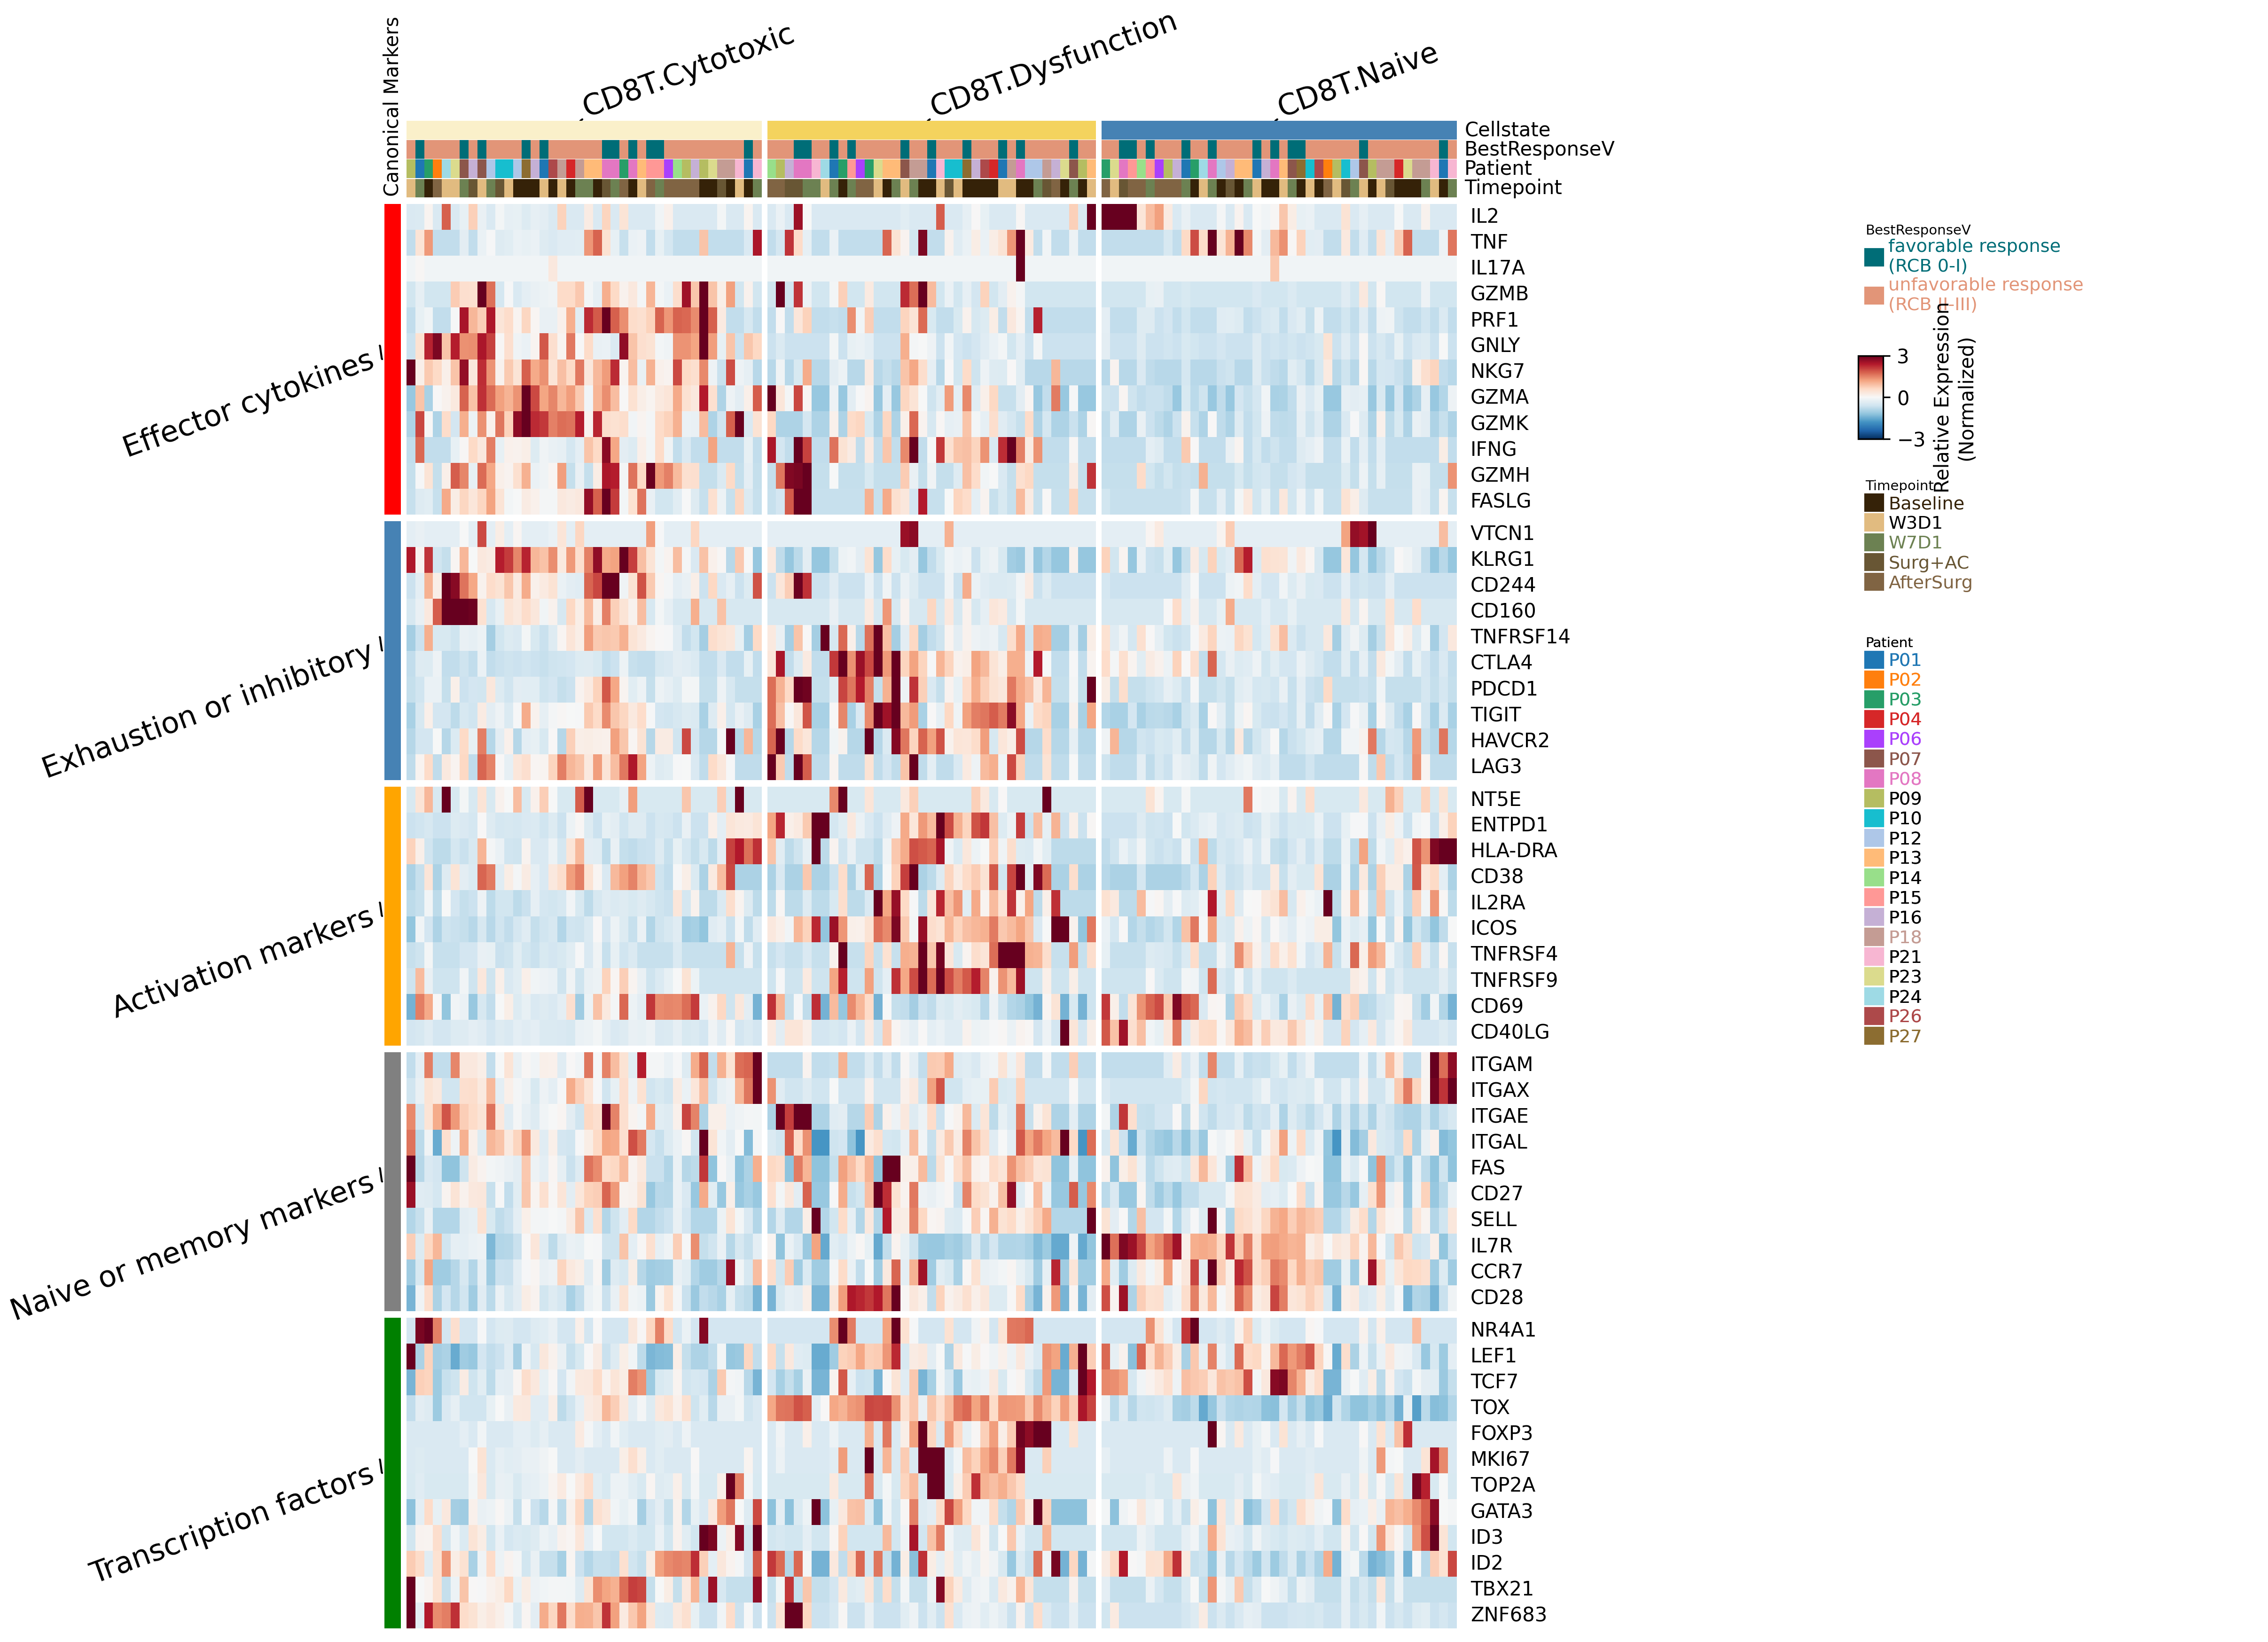

In [43]:
cd8T_custom_markers = {
    'Naive or memory markers':['CCR7','SELL','IL7R','CD28','FAS','CD27','ITGAE','ITGAL','ITGAM','ITGAX'],
    'Exhaustion or inhibitory':['PDCD1','TIGIT','HAVCR2','LAG3','CTLA4','VTCN1','CD244','KLRG1','TNFRSF14','CD160'], #'BLTA'
    'Activation markers':['CD38','ENTPD1','NT5E','CD69','IL2RA','ICOS','TNFRSF4','TNFRSF9','HLA-DRA','CD40LG'],
    'Effector cytokines':['GZMA','GZMB','GZMH','GZMK','PRF1','NKG7','GNLY','IFNG','FASLG','TNF','IL17A','IL2'],
    'Transcription factors':['LEF1','TCF7','TBX21','TOX','GATA3','ID2','ID3','NR4A1','ZNF683','FOXP3','MKI67','TOP2A'],#'EMOES','PRMD1'
}
marker_df = []
for k,v_list in cd8T_custom_markers.items():
    for v in v_list:
        marker_df.append(
            pd.Series({v:k},name='Canonical Markers')
        )
    
marker_df = pd.concat(marker_df).to_frame()
palette['Canonical Markers']={
    'Naive or memory markers':'gray',
    'Exhaustion or inhibitory':'steelblue', 
    'Activation markers':'orange',
    'Effector cytokines':'red',
    'Transcription factors':'green',
    'NK/gamma-delta T cell genes':'salmon'
}
aggregate_heatmap(adata=adata,
                  features=marker_df,
                  top_anno_columns=['Cellstate','BestResponseV','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Canonical Markers',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(10,12),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Relative Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )

# Score association

In [22]:
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0])#.map(MP_anno_map)

# attach clinical information
scores = scores.merge(obs,left_index=True,right_index=True,how='left')

# C3D1 prediction power

In [29]:
x='BestResponse'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['W3D1']),:].copy()
dt.groupby([x,'Treatment_Arm'])[random_var].nunique().rename('N_Pts').reset_index()

,BestResponse,Treatment_Arm,N_Pts
0,0-I,Chemo->Combo,2
1,II-III,Chemo->Combo,3
2,II-III,ICI->Combo,4


In [30]:
dt[x] = pd.Categorical(dt[x],['0-I','II-III'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,0-I,II-III,Dysfunction,0.040904,-0.049924,0.8075982062134412,0.931856
0,0-I,II-III,Cytotoxic,-0.014611,0.159458,0.9318563595946002,0.931856
0,0-I,II-III,Naive,0.261628,0.299128,0.5022177408389252,0.931856


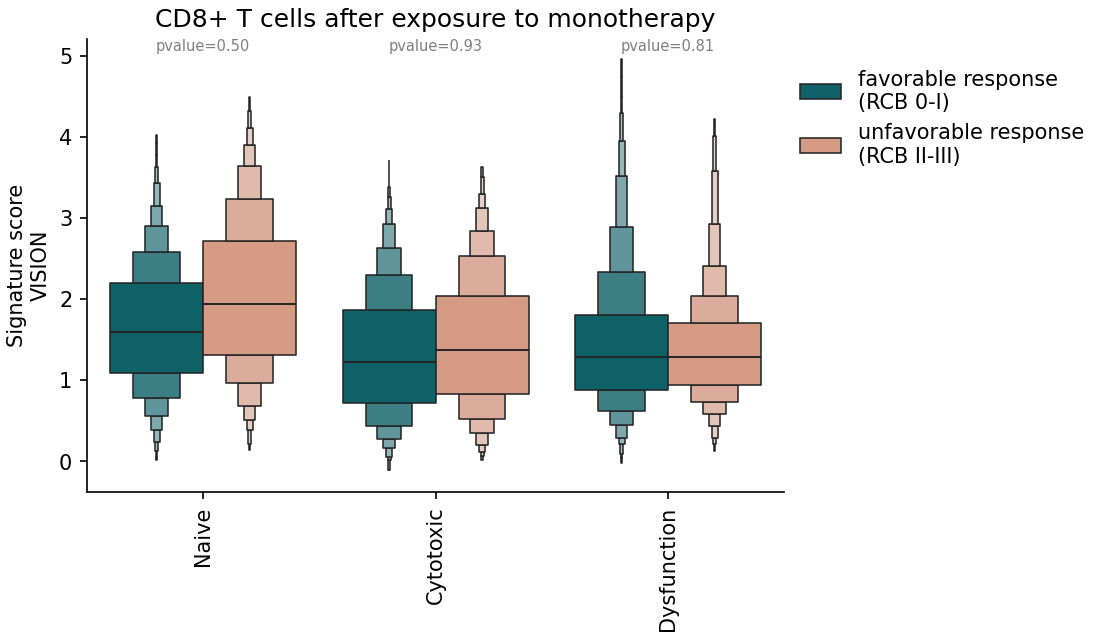

In [31]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
dt.rename(columns=MP_anno_map,inplace=True)
pvalues = result.loc[result.Y.isin(show_mps),:].set_index('Y')['Pvalue']
fig,ax=plt.subplots(1,1,dpi=150)
dt.BestResponse= dt.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                   ax=ax,
                x='variable',y='value',hue=x,
                   showfliers=False,
#                 split=True,inner="quart", fill=False,
                palette=COLOR_PAlETTE[x])
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = f"pvalue={pvalues[text]:.2f}"
    else:
        label = f"pvalue={pvalues[text]:.3f}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
ax.tick_params(axis='x',rotation=90)
n_pt_label = ','.join([ f"N({k})={v}"for k,v in dt.drop_duplicates([random_var])[x].value_counts().to_dict().items()])
ax.set(xlabel='',ylabel=f'Signature score\n{signature_method}',title=f'CD8+ T cells after exposure to monotherapy')# [{n_pt_label}]')
ax.legend(loc=(1.01,.7),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False)

# Baseline prediction power

### Differences caused by the lead-in treatment

In [128]:
x='BestResponse'
groupby = 'Treatment_Arm'
x_order=['0-I','II-III']
dt = scores.loc[(scores.Timepoint.isin(['Baseline'])),:].copy()
output_table = []
for arm,input_dt in dt.groupby(groupby):
    input_dt[x] = pd.Categorical(input_dt[x],x_order,ordered=True)
    result = lmTest(dt=input_dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
    result[groupby] = arm
    output_table.append(result)
output_table = pd.concat(output_table,axis=0).replace(MP_anno_map)
output_table.to_csv(f'{RESULT_TABLE}/LmTest/CD8T_Baseline_Prediction.csv',index=False)
pvalues = output_table.set_index(['Y',groupby])['Pvalue']
output_table

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR,Treatment_Arm
0,0-I,II-III,Dysfunction,0.347343,0.414696,0.22141912490958737,0.221419,Chemo->Combo
0,0-I,II-III,Cytotoxic,0.513469,0.732666,0.06864121727655947,0.102962,Chemo->Combo
0,0-I,II-III,Naive,0.993250,0.799687,0.023505141412823068,0.070515,Chemo->Combo
0,0-I,II-III,Cytotoxic,-0.512067,-0.589538,0.018468982764248285,0.027703,ICI->Combo
0,0-I,II-III,Dysfunction,-0.327612,-0.324347,0.00990350752554793,0.027703,ICI->Combo
0,0-I,II-III,Naive,-0.485309,-0.277965,0.13207713472970917,0.132077,ICI->Combo


### Visualization

Text(0.5, 0.98, 'CD8T+ cells from baseline samples.')

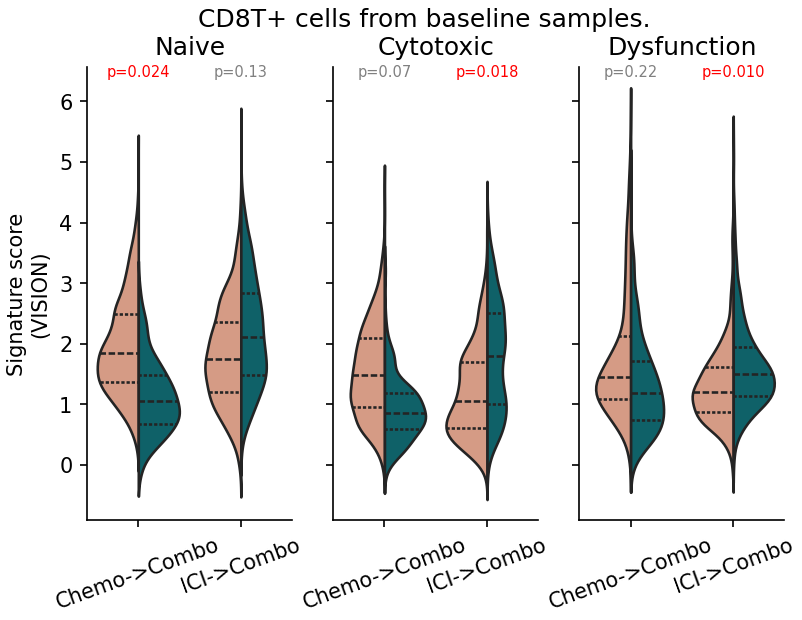

In [144]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
plt_dt = dt.rename(columns=MP_anno_map)
plt_dt.BestResponse= plt_dt.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
fig,axs=plt.subplots(1,3,dpi=150,sharey=True)
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                   ax=ax,x=groupby,y=subtype,hue=x,
                split=True,inner="quart", fill=True,
                palette=COLOR_PAlETTE[x])
    ax.legend_.remove()
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.tick_params(axis='x',rotation=20)
    y_loc =6.6
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        else:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
plt.suptitle('CD8T+ cells from baseline samples.')

### Cellular abundance

In [110]:
timepoint='Baseline'
celltype_col='Celltype'
cellstate_col = 'Cellstate'
obs = pd.read_csv(obs_path,index_col=0)
obs['BestResponseV'] = obs.BestResponse.map({'0-I':'favorable response\n(RCB 0-I)','II-III':'unfavorable response\n(RCB II-III)'})
pt_bp_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['BestResponse'].to_dict()
pt_bpV_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['BestResponseV'].to_dict()
pt_rcb_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['RCB'].to_dict()
pt_time_map = obs.drop_duplicates(subset=['Sample_Short']).set_index('Sample_Short')['Timepoint'].to_dict()

# relative abundance 
ra = (pd.crosstab([obs[celltype_col],obs[cellstate_col]],[obs[celltype_col],obs['Sample_Short']]) / obs.groupby([celltype_col])['Sample_Short'].value_counts()).T
# stats
timepoint='Baseline'
# relative abundance 
ra = (pd.crosstab([obs[celltype_col],obs[cellstate_col]],[obs[celltype_col],obs['Sample_Short']]) / obs.groupby([celltype_col])['Sample_Short'].value_counts()).T
dt = ra.loc['CD8T','CD8T']
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
from scipy.stats import ranksums
## order by the z score between R vs NR
##### stats_result on the distribution of relative abundance of each state
stats_dt = dt.apply(lambda v: pd.Series(ranksums(v[v.index.map(pt_bp_map)=='0-I'], 
                                                         v[v.index.map(pt_bp_map)=='II-III']),
                                                index=['statstics','Pvalue'],name=v.name)
                            ,axis=0).T

stats_dt

,statstics,Pvalue
Cellstate,,
CD8T.Cytotoxic,-0.462250,0.643902
CD8T.Dysfunction,1.571651,0.116032
CD8T.Naive,0.277350,0.781511


Text(0.5, 1.1, 'Malignant cells from baseline samples')

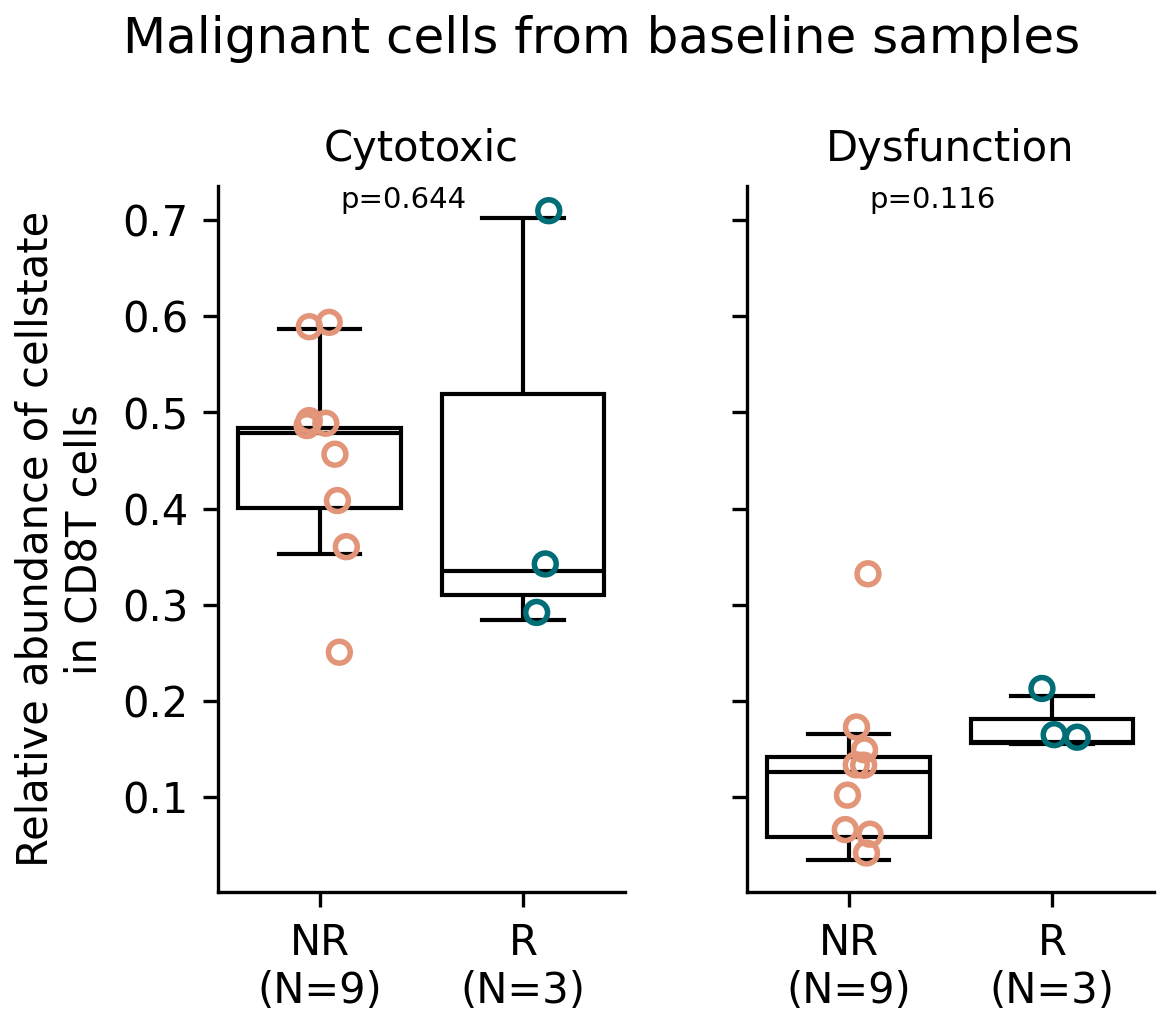

In [112]:
fig,axs = plt.subplots(1,2,figsize=(4,3),sharey=True,dpi=150)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
filled_marker_style = dict(marker='o', linestyle=':', 
                           color='darkgrey',
                           edgecolor='brown')
ax=axs[0]
celltype='CD8T'
cellstate = 'Cytotoxic'
dt = ra.loc[celltype,celltype]
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
dt['BestResponse'] = pd.Categorical(dt.index.map(pt_bpV_map),['unfavorable response\n(RCB II-III)','favorable response\n(RCB 0-I)'],ordered=True)
dt['RCB'] =  pd.Categorical(dt.index.map(pt_rcb_map),['0','I','II','III'],ordered=True)
sns.stripplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,hue='BestResponse',palette=COLOR_PAlETTE['BestResponse'], marker="$\circ$", size=10)
sns.boxplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,showfliers=False,linewidth=1,**PROPS)
pvalue = stats_dt.loc[f'{celltype}.{cellstate}','Pvalue']
ax.text(0.3,1,s=f"p={pvalue:.3f}",transform = ax.transAxes,va='top',ha='left',size=7)
ax.set(xlabel='',title=cellstate,ylabel=f'Relative abundance of cellstate\nin {celltype} cells');
ax.spines[['right','top']].set_visible(False)
xticklabels = []
for handle in ax.get_xticklabels():
    rcb = handle.get_text()
    text = {'unfavorable response\n(RCB II-III)':'NR','favorable response\n(RCB 0-I)':'R'}[rcb]
    xticklabels.append(f"{text}\n(N={(dt['BestResponse']==rcb).sum()})")
ax.set_xticklabels(xticklabels)
# ax.legend_.remove()
ax=axs[1]
celltype='CD8T'
cellstate = 'Dysfunction'
dt = ra.loc[celltype,celltype]
dt = dt.loc[dt.index.map(pt_time_map)==timepoint,:]
dt['BestResponse'] = pd.Categorical(dt.index.map(pt_bpV_map),['unfavorable response\n(RCB II-III)','favorable response\n(RCB 0-I)'],ordered=True)
dt['RCB'] =  pd.Categorical(dt.index.map(pt_rcb_map),['0','I','II','III'],ordered=True)
sns.stripplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,hue='BestResponse',palette=COLOR_PAlETTE['BestResponse'], marker="$\circ$", size=10)
sns.boxplot(data=dt,x='BestResponse',y=f'{celltype}.{cellstate}',ax=ax,showfliers=False,linewidth=1,**PROPS)
pvalue = stats_dt.loc[f'{celltype}.{cellstate}','Pvalue']
ax.text(0.3,1,s=f"p={pvalue:.3f}",transform = ax.transAxes,va='top',ha='left',size=7)
ax.set(xlabel='',title=cellstate,ylabel=f'Relative abundance of cellstate\nin {celltype} cells');
ax.spines[['right','top']].set_visible(False)
xticklabels = []
for handle in ax.get_xticklabels():
    rcb = handle.get_text()
    text = {'unfavorable response\n(RCB II-III)':'NR','favorable response\n(RCB 0-I)':'R'}[rcb]
    xticklabels.append(f"{text}\n(N={(dt['BestResponse']==rcb).sum()})")
ax.set_xticklabels(xticklabels)
# ax.legend(loc=(1.01,0),title='RCB')
plt.subplots_adjust(wspace=.3)
plt.suptitle('Malignant cells from baseline samples',y=1.1)

# Paired pt from Baselint to W3D1

In [82]:
x='Timepoint'
explored_z='Treatment_Arm'
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W3D1']),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,5
1,W3D1,5


In [83]:
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,Treatment_Arm,FDR
0,Baseline,W3D1,Dysfunction,0.119629,0.050852,0.004279905761291051,Chemo->Combo+ICI->Combo,0.00428
0,Baseline,W3D1,Dysfunction,0.068039,0.050852,0.1525156661339875,Chemo->Combo,0.152516
0,Baseline,W3D1,Dysfunction,0.29754,0.050852,0.0012497890454924473,ICI->Combo,0.00287
0,Baseline,W3D1,Naive,0.512249,0.111626,2.66981932415343e-39,Chemo->Combo+ICI->Combo,0.0
0,Baseline,W3D1,Naive,0.616703,0.111626,1.64732977565972e-44,Chemo->Combo,0.0
0,Baseline,W3D1,Naive,0.154276,0.111626,0.06151887112210351,ICI->Combo,0.061519
0,Baseline,W3D1,Cytotoxic,0.438982,0.46074,1.4313492477467955e-27,Chemo->Combo+ICI->Combo,0.0
0,Baseline,W3D1,Cytotoxic,0.499469,0.46074,4.1007317414749015e-25,Chemo->Combo,0.0
0,Baseline,W3D1,Cytotoxic,0.214083,0.46074,0.001913642884678759,ICI->Combo,0.00287


# Paired pt timepoint- treatment induced effect

### In Non-responder

In [84]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1'])&
                (scores.BestResponse=='II-III'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,3
1,W7D1,3


In [85]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W7D1,Naive,-0.134514,-0.259547,0.01612511500163795,0.031215
0,Baseline,W7D1,Dysfunction,0.035863,-0.002152,0.43733663114643073,0.437337
0,Baseline,W7D1,Cytotoxic,0.119615,0.011066,0.020810133573885715,0.031215


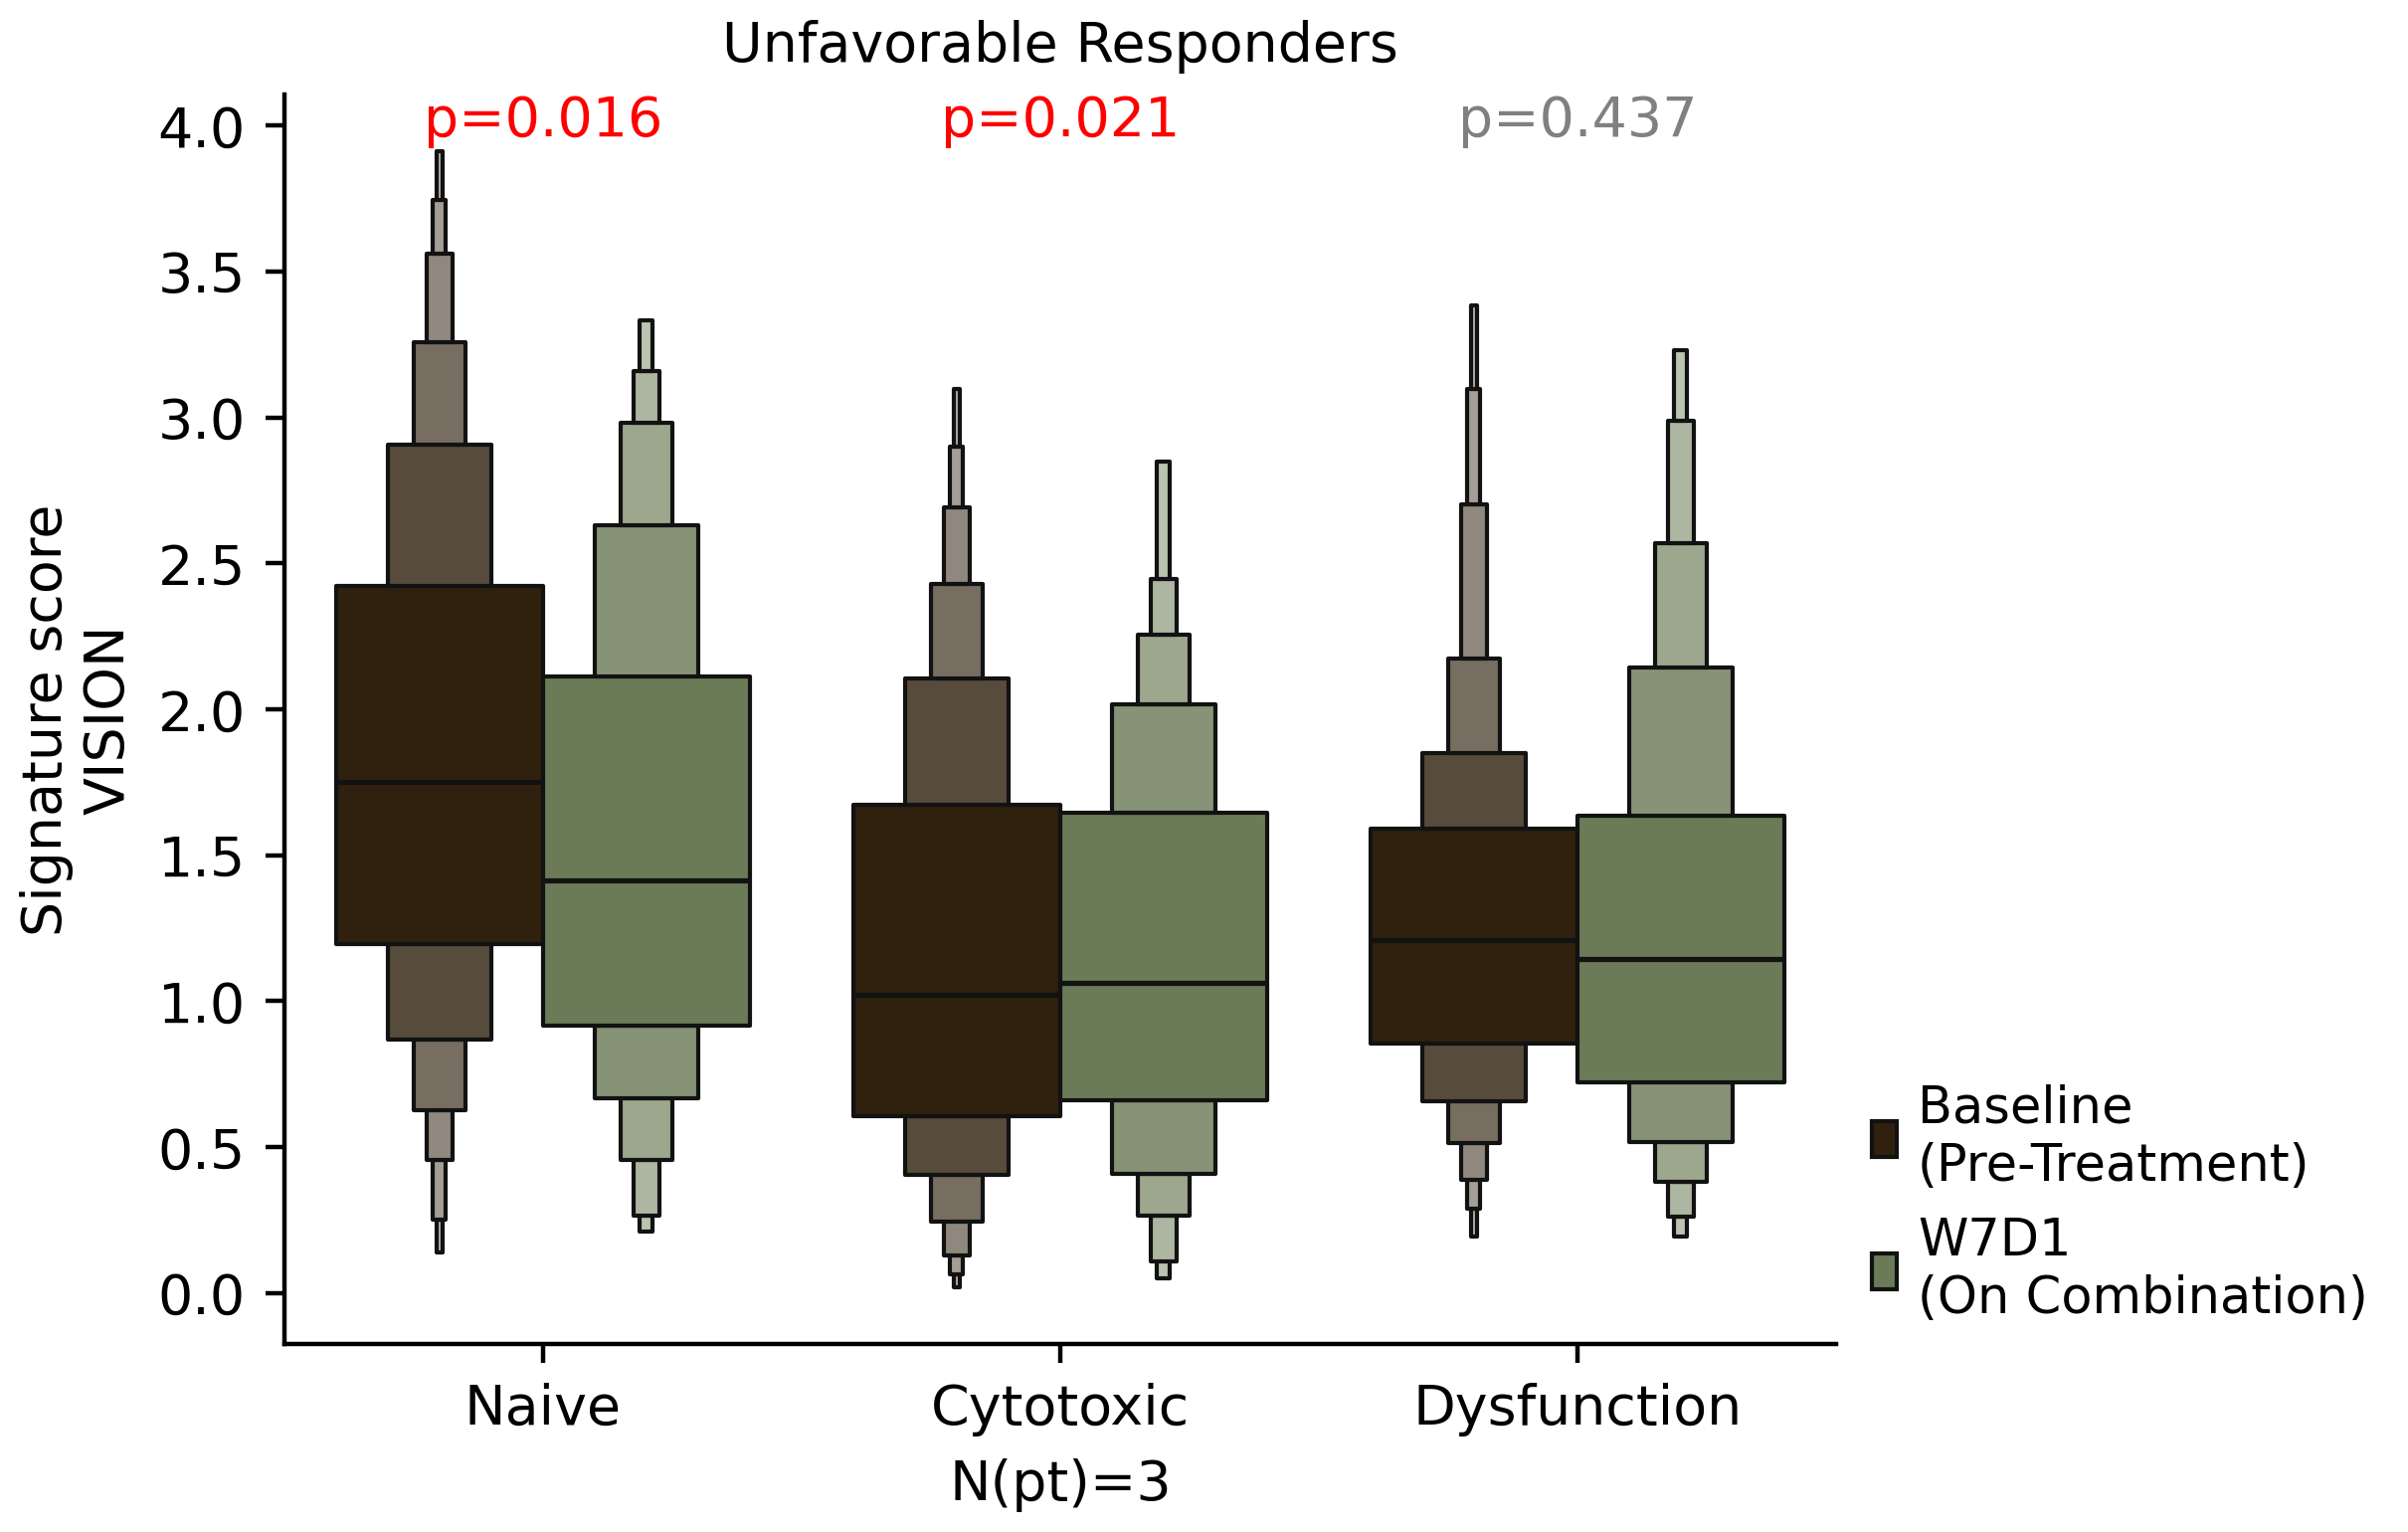

In [86]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)

plot_rename = {'Baseline':'Baseline\n(Pre-Treatment)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]

fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=200)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.3f}"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Unfavorable Responders')
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.grid(False)
ax.spines[['right','top']].set_visible(False);

### In Responders

In [87]:
x='Timepoint'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint.isin(['Baseline','W7D1'])&
                (scores.BestResponse=='0-I'),:].copy()
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
dt.groupby([x])[random_var].nunique().rename('N_Pts').reset_index()

,Timepoint,N_Pts
0,Baseline,2
1,W7D1,2


In [88]:
dt[x] = pd.Categorical(dt[x],['Baseline','W7D1'],ordered=True)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
significant_MP = result.Y[(result.Pvalue<0.05)&(result[f'log2FC'].abs()>.5)].unique().tolist()
result.Y =  result.Y.map(MP_anno_map)
result

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,Baseline,W7D1,Dysfunction,0.085533,-0.277752,0.022032742221145547,0.022033
0,Baseline,W7D1,Naive,0.117923,-0.195432,0.0036985793980376103,0.005548
0,Baseline,W7D1,Cytotoxic,0.638251,0.448007,6.391613728342485e-58,0.0


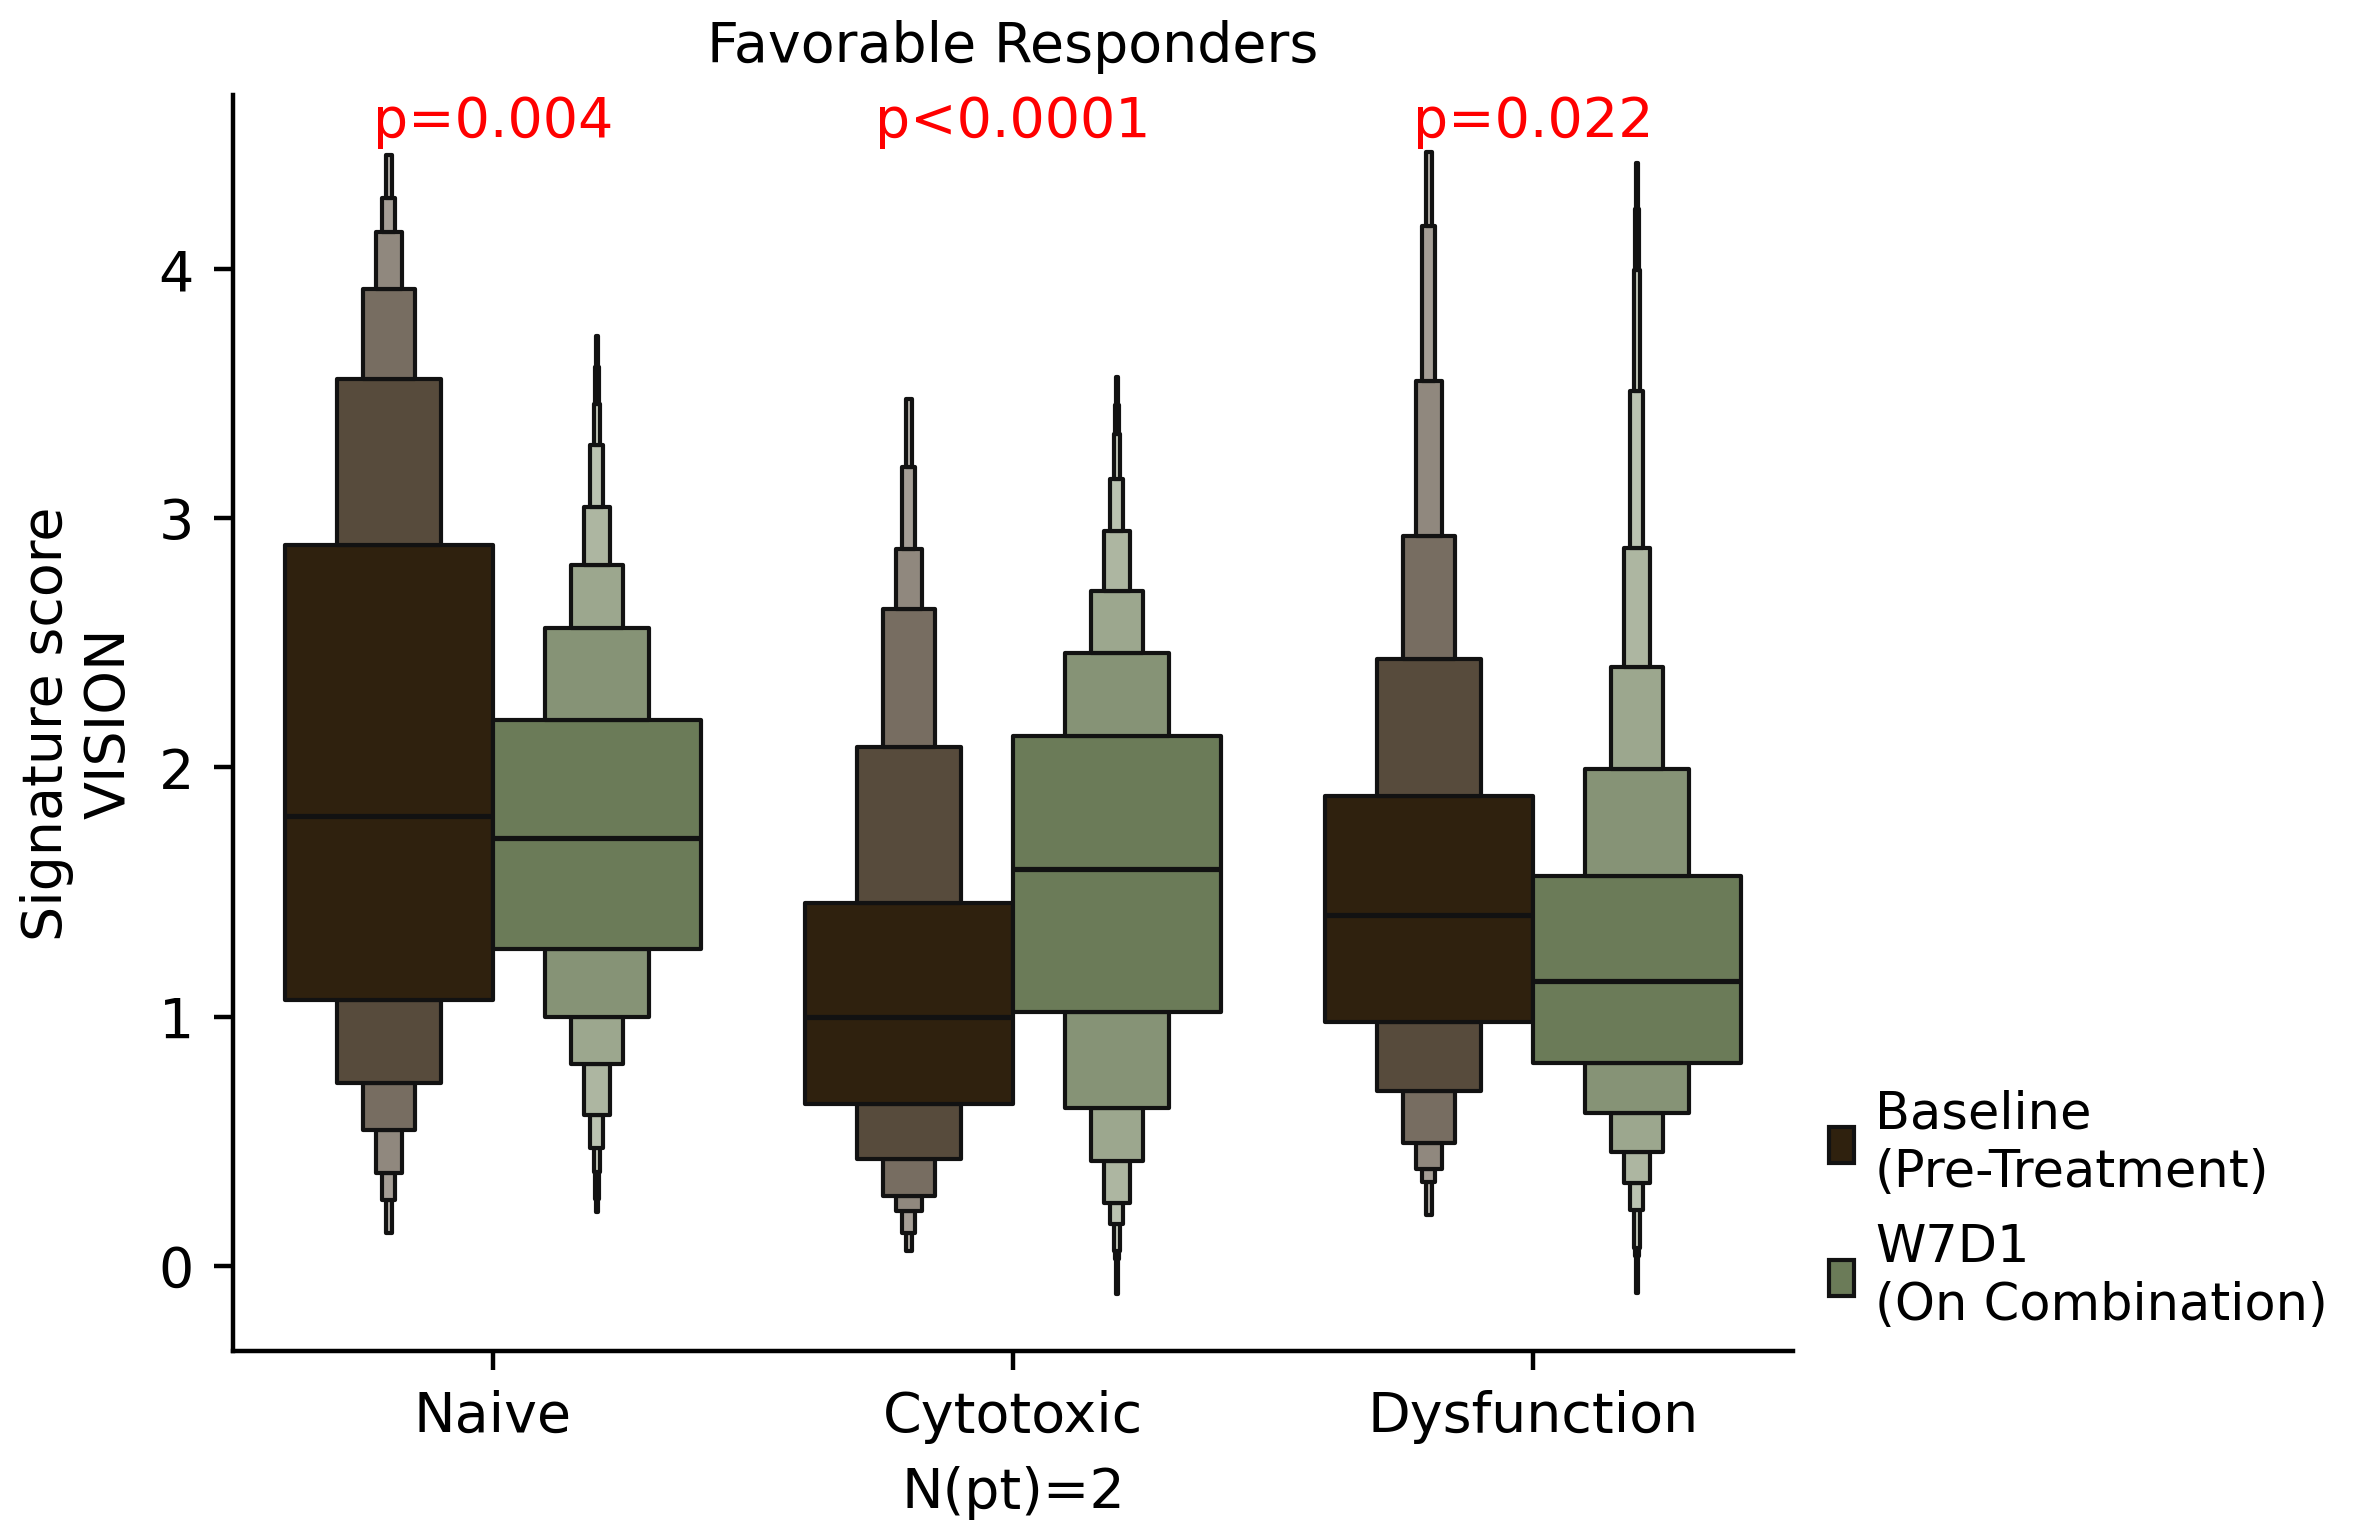

In [89]:
show_mps = ['Naive','Cytotoxic','Dysfunction']
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
plot_rename = {'Baseline':'Baseline\n(Pre-Treatment)','W7D1':'W7D1\n(On Combination)'}
dt[x] = dt[x].replace(plot_rename)
palette = {}
for k,v in plot_rename.items():
    palette[v] = COLOR_PAlETTE[x][k]

fig,ax=plt.subplots(1,1,figsize=(5,4),dpi=200)
sns.boxenplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=palette,ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    label = f"p={pvalues[text]:.3f}" if pvalues[text] >= 0.0001 else "p<0.0001"
    if pvalues[text] >= 0.05:
        c='gray'
    else:
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
ax.set(xlabel=f"N(pt)={dt['Patient'].nunique()}",ylabel=f"Signature score\n{signature_method}",title='Favorable Responders')
# ax.set_xticklabels([])
ax.grid(False)
ax.legend(loc=(1.01,0),frameon=False,ncol=1)
ax.spines[['right','top']].set_visible(False);

# Cytokine

In [90]:
cytosig_pvalue = pd.read_csv(f'{RESULT_TABLE}/cytoSig_pvalue.csv',index_col=0)
cytosig = pd.read_csv(f'{RESULT_TABLE}/cytoSig_zscore.csv',index_col=0)
cytosig.columns = cytosig.columns.map(lambda x:x.split('.')[1]) # remove the cell type prefix
cytosig_pvalue.columns = cytosig_pvalue.columns.map(lambda x:x.split('.')[1]) # remove the cell type prefix
cytosig = cytosig[adata.obs.index.intersection(cytosig.columns)].T
cytosig_pvalue = cytosig_pvalue[adata.obs.index.intersection(cytosig_pvalue.columns)].T
cytosig[cytosig_pvalue<=0.1]=0

In [91]:
ns_cytokines = (cytosig_pvalue<0.1).mean()

In [92]:
cytosig = cytosig.loc[:,ns_cytokines > 0.2]
cytosig.columns =cytosig.columns +' Cytokine'

In [93]:
ol_bcs = cytosig.index.intersection(adata.obs.index)
del adata.uns
adata_new = adata[ol_bcs].copy()

In [94]:
for c in cytosig:
    adata_new.obs[c] = cytosig[c]

In [95]:
from statsmodels.stats.multitest import multipletests
de_cyto={}
data  = adata_new.obs[cytosig.columns.tolist()+['Cellstate','Sample_Short']].copy()
for celltype,expr in data.groupby(['Cellstate']):
    expr = expr.groupby('Sample_Short').mean().dropna(how='all',axis=0)
    ctrl = data.loc[data.index.difference(expr.index),
                       :].drop(['Cellstate'],axis=1
                              ).groupby('Sample_Short').mean().dropna(how='all',axis=0)
    stats_res = expr.apply(lambda c: pd.Series(scipy.stats.ranksums(c.values,ctrl[c.name].values),index=['Zscore','Pvalue']),axis=0).T
    stats_res['FDR'] = multipletests(stats_res['Pvalue'], method='fdr_bh')[1]
    de_cyto[celltype] = stats_res

In [96]:
de_cytokines={}
for celltype,dec in de_cyto.items():
    de_cytokines[celltype] = dec.index[(dec['Pvalue']<0.05)&
                                      (dec['Zscore']>0)].str.replace('_',' ').tolist()
de_cytokines

{'CD8T.Cytotoxic': [],
 'CD8T.Dysfunction': ['IL15 Cytokine'],
 'CD8T.Naive': ['GCSF Cytokine']}

In [97]:
uniq_cyto = pd.Series([y for x in [*de_cytokines.values()] for y in x]).value_counts()
uniq_cyto

IL15 Cytokine    1
GCSF Cytokine    1
dtype: int64

In [98]:
dt = adata_new.obs[['IL15 Cytokine','Patient','Cellstate']].groupby(['Patient','Cellstate']).mean().reset_index()
dt.head()

,Patient,Cellstate,IL15 Cytokine
0,P01,CD8T.Cytotoxic,-0.218997
1,P01,CD8T.Dysfunction,0.108644
2,P01,CD8T.Naive,-0.042868
3,P03,CD8T.Cytotoxic,-0.435886
4,P03,CD8T.Dysfunction,-0.390854


[Text(0.5, 0, '')]

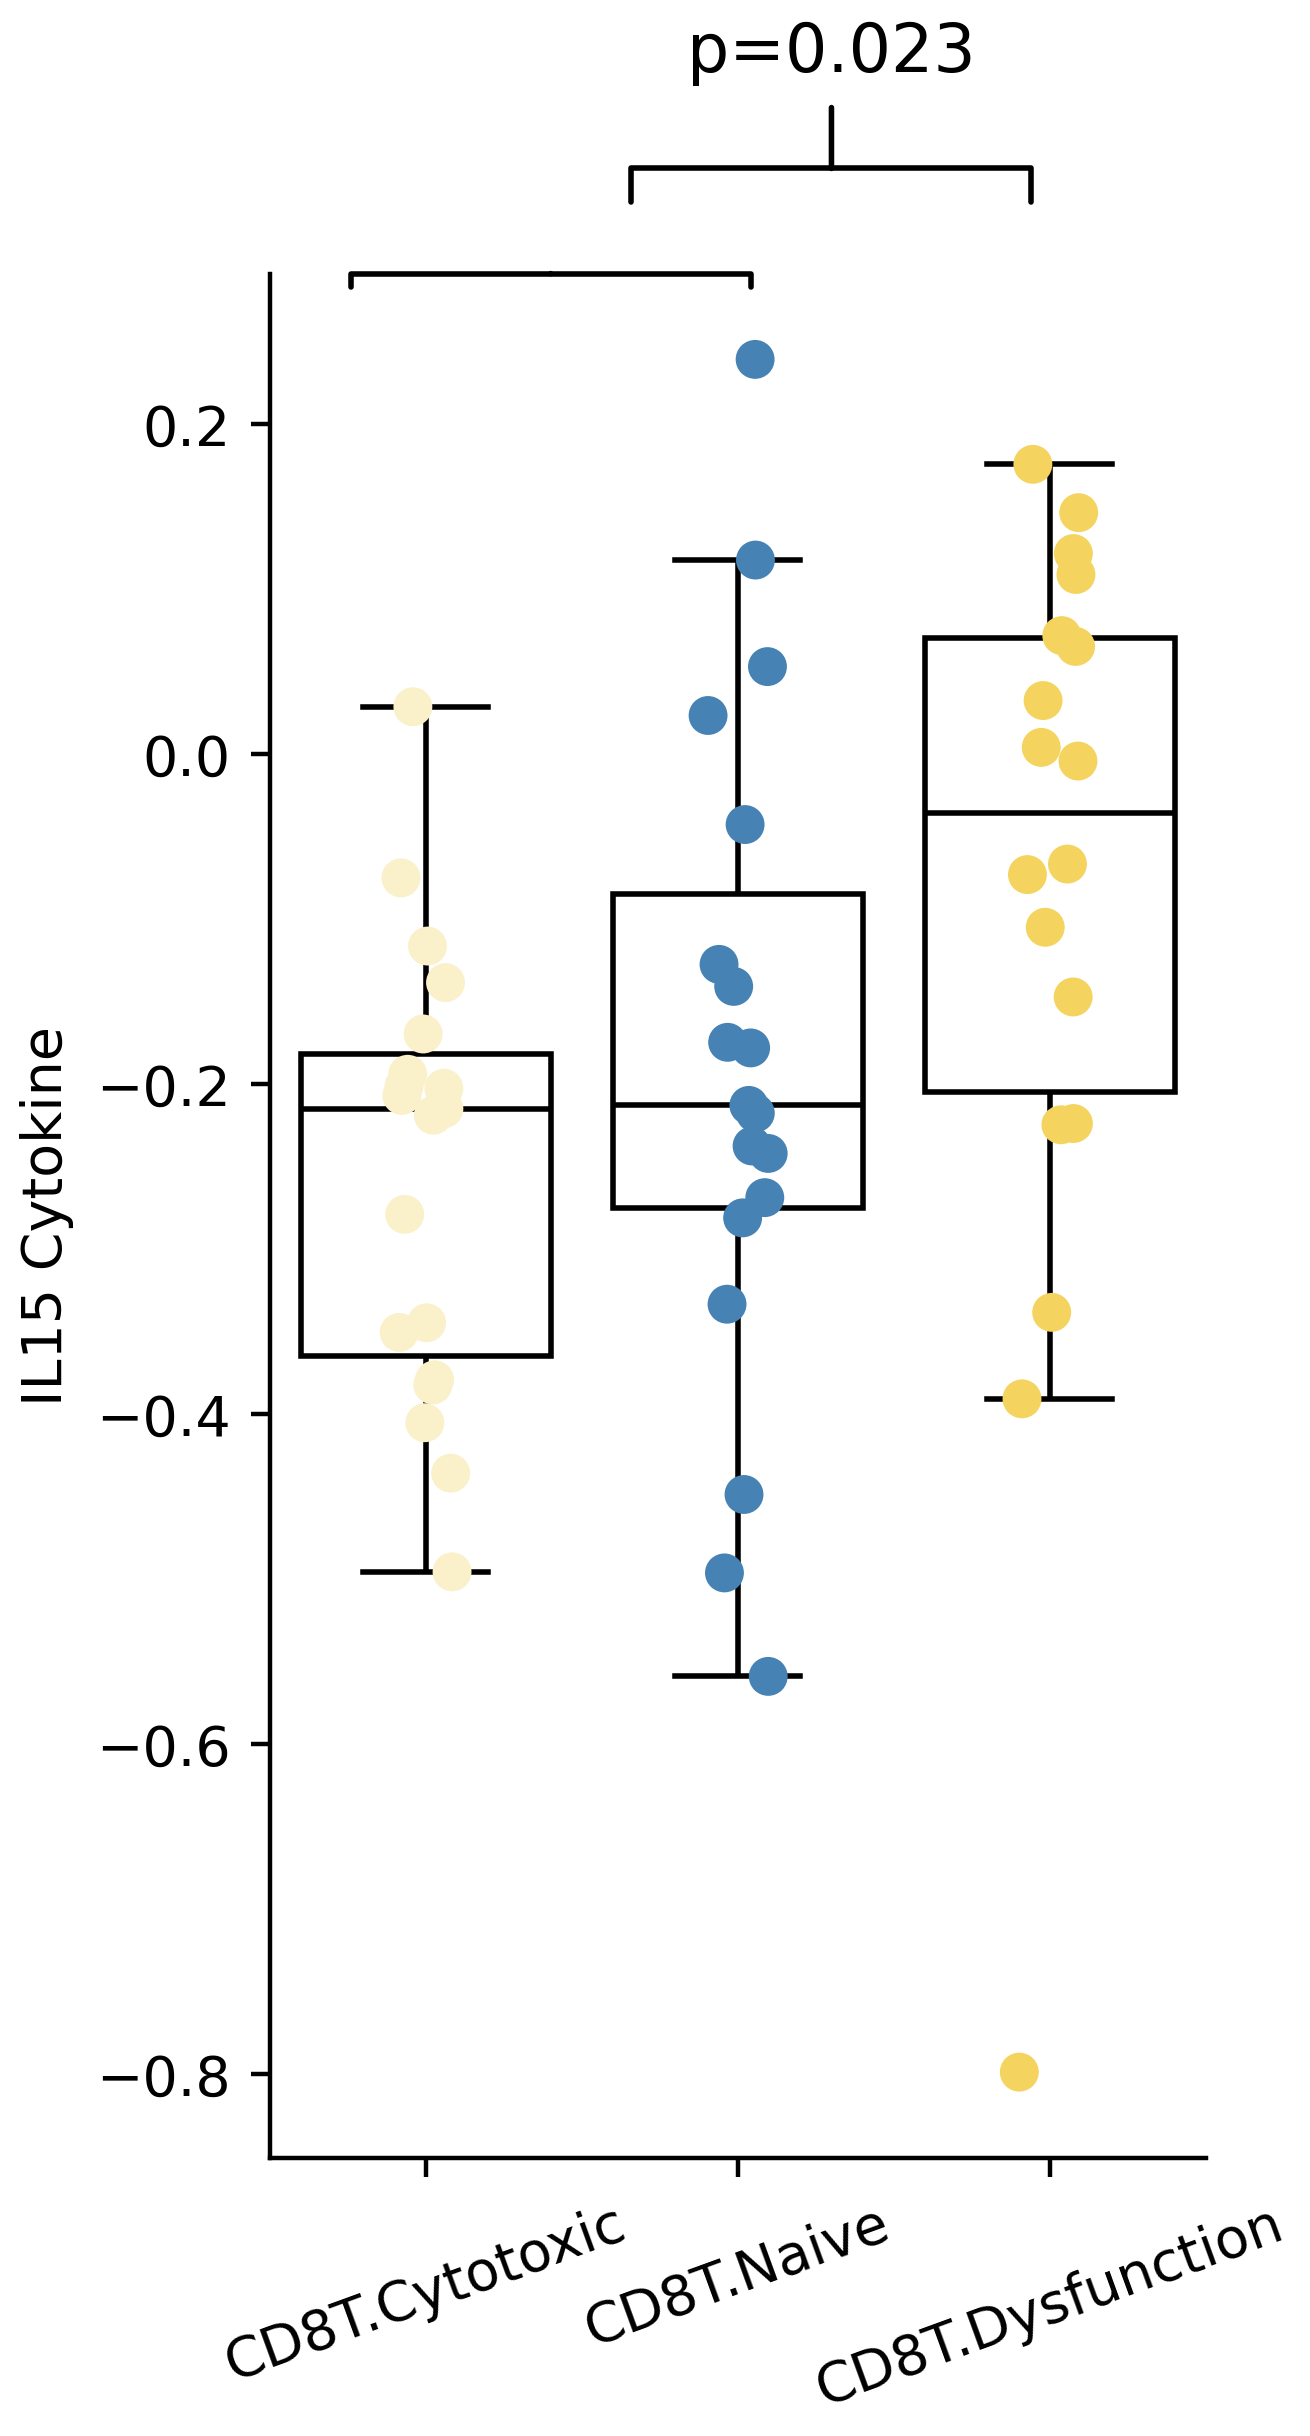

In [99]:
fig,ax=plt.subplots(1,1,figsize=(3,6),dpi=200)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.stripplot(data=dt,x='Cellstate',y='IL15 Cytokine',
              order=['CD8T.Cytotoxic','CD8T.Naive','CD8T.Dysfunction'],
              ax=ax,palette=COLOR_PAlETTE['Cellstate'],size=7)
sns.boxplot(data=dt,x='Cellstate',y='IL15 Cytokine',
            order=['CD8T.Cytotoxic','CD8T.Naive','CD8T.Dysfunction'],
            ax=ax,showfliers=False,linewidth=1,**PROPS)
ax.tick_params(axis='x',rotation=20)
pvalue = de_cyto['CD8T.Dysfunction'].loc['IL15 Cytokine','Pvalue']
ax.annotate(f"p={pvalue:.3f}", xy=(0.6, 1.05), xytext=(0.6, 1.1), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.5', lw=1, color='k'))
ax.annotate('', xy=(0.3, 1), xytext=(0.3, 1.0001), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.2', lw=1, color='k'))
ax.set(xlabel='')